In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ---
# Импорт системных и утилитарных библиотек
import os                                           # Работа с файловой системой
import time                                         # Засечки времени
from datetime import datetime                       # Форматирование временных меток
import json                                         # Работа с JSON-файлами
import re                                           # Регулярные выражения
import joblib                                       # Сериализация моделей и объектов
from collections import defaultdict                 # Расширенные словари
from typing import Tuple                            # Аннотации типов

# Импорт базовых научных библиотек
import numpy as np                                  # Массивы и численные операции
import pandas as pd                                 # Работа с таблицами и DataFrame

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt                     # Построение графиков
import seaborn as sns                               # Расширенные визуализации

# Импорт библиотек для веб-скрапинга
import requests                                     # HTTP-запросы
from bs4 import BeautifulSoup                       # Парсинг HTML

# Импорт статистических инструментов
from scipy.stats import pearsonr                    # Корреляционный анализ

# Импорт инструментов машинного обучения (sklearn)
from sklearn.model_selection import train_test_split, KFold                     # Разделение данных и кросс-валидация
from sklearn.ensemble import RandomForestRegressor                              # Модель случайного леса
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, MultiLabelBinarizer  # Масштабирование и кодирование
from sklearn.feature_selection import chi2                                      # Статистическая фильтрация признаков
from sklearn.feature_extraction.text import TfidfVectorizer                     # Векторизация текста
from sklearn.feature_extraction import text                                     # Стоп-слова и текстовые утилиты
from sklearn.cluster import KMeans                                              # Кластеризация
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error  # Метрики качества
from sklearn import metrics                                                     # Общие метрики
from statsmodels.stats.outliers_influence import variance_inflation_factor      # VIF определитель

from sklearn.feature_selection import VarianceThreshold                         # Пороговый VIF
from sklearn.preprocessing import StandardScaler                                # Масштабирование
import shap                                                                     # Интерпретируемость моделей


# Импорт категориального кодировщика
from category_encoders import TargetEncoder  # Целевой кодировщик категориальных признаков

# Импорт инструментов анализа текста
from textblob import TextBlob  # Обработка текста и анализ тональности

# Импорт библиотек для работы с PyTorch
import torch                                                        # Основной фреймворк
import torch.nn as nn                                               # Нейронные слои и функции активации
from torch.utils.data import TensorDataset, DataLoader              # Обёртки для данных и загрузка батчей
from torchmetrics.regression import MeanAbsolutePercentageError     # Метрика MAPE для регрессии


In [4]:
# Define a basic feedforward regression model
# Определяем простую нейросеть для регрессии
class HotelRegressor(nn.Module):
    def __init__(self, input_dim):
        super(HotelRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


## Цель проекта

Компания сталкивается с проблемой недобросовестных отелей, которые искусственно завышают свои рейтинги. Чтобы решить эту задачу, целью проекта является разработка предсказательной модели, которая будет оценивать рейтинг отеля на основе доступных признаков. Если предсказания модели значительно отклоняются от фактических рейтингов, это может свидетельствовать о подозрительном поведении. Такие отели следует помечать для дальнейшего расследования.

**Примечание**: Проект является учебным входящим в программу SkillFactory DS. Поэтому акцент проекта смещен от результативности модели
к самому процессу ее построения и применяемых для этого методов.

**Ограничения**:
Так как проект учебный разработка модели была ограничена на стадии ее отладки и доведения показателей ее результативности до высокой степени.
Возможные методы улучщения модели упомянуты в разделе 13 README.md.


## Первичный анализ набора данных hotels

Прежде чем приступать к построению предсказательных моделей, важно понять структуру и содержание набора данных. Ниже приведено краткое резюме первичного анализа:

- **Обзор схемы**: Набор данных содержит множество признаков, описывающих характеристики отелей, метрики отзывов, а также, возможно, атрибуты, связанные с расположением или обслуживанием. Каждая строка представляет собой наблюдение по одному отелю.

- **Типы данных**: В наборе представлены как числовые (int64, float64), так и категориальные (object) столбцы. Числовые признаки можно использовать напрямую в моделировании, а категориальные — требуют предварительного кодирования.

- **Количество столбцов**: Набор данных включает *N* столбцов (замените на фактическое число), предоставляя богатое пространство признаков для анализа и построения моделей.

- **Описательная статистика** (`describe()`): Сводная статистика позволяет оценить центральные тенденции и разброс числовых признаков:
  - Среднее значение и стандартное отклонение помогают определить необходимость масштабирования признаков.
  - Минимальные и максимальные значения выявляют потенциальные выбросы.
  - Количество значений (`count`) показывает полноту данных или наличие пропусков в каждом столбце.

Это базовое понимание направляет дальнейшую работу по созданию признаков, выбору модели и стратегии предобработки.



In [3]:
hotels_origin = pd.read_csv('data/hotels.csv')
hotels = hotels_origin.copy()
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [5]:
display(hotels.describe(include = 'all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel_address,386803,1493,163 Marsh Wall Docklands Tower Hamlets London ...,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additional_number_of_scoring,386803.0,NaN,NaN,NaN,498.246536,500.258012,1.0,169.0,342.0,660.0,2682.0
review_date,386803,731,8/2/2017,1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_score,386803.0,NaN,NaN,NaN,8.397231,0.547881,5.2,8.1,8.4,8.8,9.8
hotel_name,386803,1492,Britannia International Hotel Canary Wharf,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_nationality,386803,225,United Kingdom,184033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_review,386803,248828,No Negative,95907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,386803.0,NaN,NaN,NaN,18.538988,29.703369,0.0,2.0,9.0,23.0,408.0
total_number_of_reviews,386803.0,NaN,NaN,NaN,2743.992042,2316.457018,43.0,1161.0,2134.0,3613.0,16670.0
positive_review,386803,311737,No Positive,26885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Этап 1. Обзор набора данных: `hotels`

Набор данных содержит **386 803 записи** и **17 столбцов**, представляющих отзывы об отелях и сопутствующую метаинформацию. Ниже приведена структура и рекомендации по моделированию и разведывательному анализу:

### Структура схемы
- **Числовые столбцы** (`int64`, `float64`):  
  Подходят для моделирования и статистического анализа  
  - `additional_number_of_scoring`  
  - `review_total_negative_word_counts`  
  - `review_total_positive_word_counts`  
  - `total_number_of_reviews`  
  - `total_number_of_reviews_reviewer_has_given`  
  - `average_score`, `reviewer_score`  
  - `lat`, `lng`

- **Категориальные/текстовые столбцы** (`object`):  
  Требуют кодирования или NLP-предобработки  
  - `hotel_address`, `hotel_name`, `reviewer_nationality`  
  - `negative_review`, `positive_review`  
  - `tags`, `days_since_review`

- **Столбец с датой**:  
  - `review_date` — можно извлечь временные признаки (месяц, год, день недели)

### Целевая переменная
- `reviewer_score` — вероятная целевая переменная для регрессионного моделирования

### Рекомендуемые компоненты EDA
- Проверка **пропущенных значений** (все столбцы, по-видимому, заполнены)  
- **Гистограммы** распределения числовых признаков  
- **Боксплоты** для выявления выбросов  
- **Матрица корреляций** для оценки связей между признаками  
- Анализ **длины текста** в отзывах  
- **Геопространственная визуализация** по координатам `lat` и `lng`  
- **Тренды по времени** на основе `review_date` и `days_since_review`

### Рекомендации по моделированию
- Использовать числовые признаки напрямую  
- Кодировать категориальные переменные (например, one-hot или label encoding)  
- Применить NLP-подходы (TF-IDF, эмбеддинги) к тексту отзывов  
- Провести инженерную обработку признаков из `tags`, `review_date` и геолокации

Этот базовый анализ поможет сформировать стратегию выбора признаков, предобработки и построения модели.


In [6]:
# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

## Разведочный запуск модели: RandomForestRegressor

Для установления базового уровня предсказательной точности был проведён первичный запуск модели `RandomForestRegressor`. Перед обучением все столбцы с типом данных `object` были удалены, чтобы обеспечить совместимость с числовыми требованиями библиотеки scikit-learn.

### Сводка настройки
- **Целевая переменная**: `reviewer_score`  
- **Модель**: `RandomForestRegressor` (ансамблевая, нелинейная)  
- **Предобработка**: удалены все нечисловые (`object`) столбцы  
- **Признаковое пространство**: включает только числовые и производные от даты признаки

### Цель запуска
Этот этап служит быстрой диагностикой для:
- Оценки базовой точности предсказаний  
- Выявления наиболее значимых числовых признаков  
- Обнаружения потенциальных утечек данных или признаков переобучения  
- Определения направлений для инженерии признаков и настройки модели

### Следующие шаги
- Оценить метрики качества модели (например, MAPE, RMSE)  
- Визуализировать предсказанные значения против фактических  
- Повторно включить закодированные категориальные признаки и сигналы из текстов отзывов  
- Сравнить с линейными моделями и нейросетями

Этот разведочный запуск подтверждает применимость регрессионного подхода и помогает спроектировать более устойчивые пайплайны.


In [7]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим

object_columns = [s for s in hotels.columns if hotels[s].dtype == 'object']

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X1 = hotels.drop(['reviewer_score'], axis = 1).drop(object_columns, axis = 1)  
y1 = hotels['reviewer_score'] 

In [8]:
# Check the data info after removing object columns
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 8 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   lat                                         386803 non-null  float64
 7   lng                                         386803 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 23.6 MB


In [8]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.25, random_state=42)

In [42]:
# Create function to generate model logging names
# Создаем функцию для генерации имен файлов моделей с временными метками

def model_logging_name(path: str, timestamp: str) -> str:
    """
    Appends a timestamp to the model filename before its extension.

    Args:
        path (str): Original model path, e.g., 'models/pytorch/hotel_reg_X2.pt'
        timestamp (str): Timestamp string, e.g., '2025-10-24 11:47'

    Returns:
        str: New path with timestamp, e.g., 'models/pytorch/hotel_reg_X2_2025-10-24_11-47.pt'

    Функция добавляет временную метку к имени файла модели перед его расширением.
    """
    # Sanitize timestamp for filenames
    safe_timestamp = timestamp.replace(":", "-").replace(" ", "_")

    # Split path into directory, base name, and extension
    dir_name, base_name = os.path.split(path)
    name, ext = os.path.splitext(base_name)

    # Construct new filename
    new_name = f"{name}_{safe_timestamp}{ext}"
    return os.path.join(dir_name, new_name)


In [ ]:
# Initialize loss function and log dictionary
criterion = nn.MSELoss()
loss_log = {}

# Создаём модель

# Устанавливаем переменные для записи журнала
model_name = "RandomForestRegressor.v0"
run_number = 1
run_comments = "Run 1. The model processes X1 set of unengineered raw features, totally 6"
train_losses = []
val_losses = []
batch_size = 0


model_path = "models/sklearn/regr_rf_X1.joblib"

# Инициализируем модель случайного леса с 100 деревьями из файла если она уже была записана
# или создаем ее
if os.path.exists(model_path):
    regr = joblib.load(model_path)
    print("Model loaded from file.")
else:
    regr = RandomForestRegressor(n_estimators=100, random_state=42)
    print("New model initialized.")

# Указываем на каком процессоре была обучена модель
processor = "CPU" # or "GPU" based on where the model was run


# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)

# Start timer
start_time = time.time()
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

# Stop timer
end_time = time.time()
runtime_sec = round(end_time - start_time, 3)

time_st = datetime.now().strftime("%Y-%m-%d %H:%M")

# Сохраняем модель
model_log_name = model_logging_name(model_path, time_st)
joblib.dump(regr, model_log_name)
print("Model saved to:", model_log_name)

Model loaded from file.
Model saved to: models/sklearn/regr_rf_X1.joblib


In [11]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

# Convert predictions and targets to tensors for MSE calculation
# For this purpose I introduce Torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Define loss function and compute MSE
criterion = torch.nn.MSELoss()
mse_loss = criterion(y_pred_tensor, y_test_tensor).item()

# Записываем результаты в лог
loss_log[model_name] = {
    "Model": model_name,
    "Model run number": run_number,
    "Processor": processor,
    "MSE Loss": round(mse_loss, 4),
    "MAPE (%)": round(mape, 4),
    "Runtime (s)": runtime_sec,
    "Batch size:": batch_size if batch_size else None,
    "Batch training loss": round(train_losses[-1], 4) if train_losses else None,
    "Batch validation loss": round(val_losses[-1], 4) if val_losses else None,
    "Comments": run_comments
}


print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('MSE: ', mse_loss)
print('Runtime: ', runtime_sec)

MAPE:  0.14136429245712825
MSE:  1.7453724145889282
Runtime:  5.568


In [ ]:
# Record loss_log into file

def save_loss_log(log_dict, filename="loss_log.json", folder="logs"):
    """
    Save or update a loss log dictionary to a JSON file inside a specified folder.
    """
    os.makedirs(folder, exist_ok=True)
    log_path = os.path.join(folder, filename)

    # Safely load existing log
    if os.path.exists(log_path):
        try:
            with open(log_path, "r") as f:
                content = f.read().strip()
                existing_log = json.loads(content) if content else {}
        except json.JSONDecodeError:
            print(f"⚠️ Warning: {filename} is invalid or corrupted. Starting fresh.")
            existing_log = {}
    else:
        existing_log = {}

    # Update and save
    existing_log.update(log_dict)
    with open(log_path, "w") as f:
        json.dump(existing_log, f, indent=4)

# Save the loss log to a JSON file
save_loss_log(loss_log)



## Это был ПЕРВЫЙ прогон модели

**Достигнутый результат**:

-- MAPE: 0.14138520089555476




### Оценка модели: MAPE

Разведочный запуск модели дал значение **средней абсолютной процентной ошибки (MAPE)** равное **0.1414**, то есть примерно **14.14%**. Это означает, что в среднем предсказания модели отклоняются от фактического значения `reviewer_score` на 14%.

### Интерпретация
- Значение MAPE ниже 15% говорит о том, что модель улавливает значимые закономерности в данных  
- Тем не менее, есть потенциал для улучшения — особенно в снижении разброса предсказаний и уточнении входных признаков

### Следующие шаги
- Повторно включить закодированные категориальные признаки и сигналы из текстов отзывов  
- Настроить гиперпараметры модели (например, глубину деревьев, количество деревьев)  
- Сравнить с альтернативными моделями (линейная регрессия, нейросети)  
- Визуализировать ошибки предсказаний по диапазонам оценок, чтобы выявить возможные смещения

Это значение MAPE служит надёжной отправной точкой для итеративного улучшения модели и инженерии признаков.



# Этап 2. Раздел обработки признаков

In [14]:
# Числовые признаки
num_cols = [col for col in hotels.columns if hotels[col].dtype.name in ['float64', 'int64']]

# Категориальные признаки
cat_cols = [col for col in hotels.columns if hotels[col].dtype.name in ['object', 'category']]
print('Числовые признаки:', num_cols)
print('Категориальные признаки:', cat_cols)

Числовые признаки: ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']
Категориальные признаки: ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


### Инженерия признака: `countries`

В рамках разведывательного анализа данных и инженерии признаков мы создали новый признак `countries`, извлекая названия стран из поля `hotel_address`. Этот шаг был направлен на захват географического контекста, который может влиять на рейтинги отелей и поведение рецензентов.

### Что было сделано
- Проанализированы строки `hotel_address` для выделения названий стран  
- Рассматривалась возможность извлечения названий городов для более детальной градации  
- Оценена целесообразность использования геолокационных данных (`lat`, `lng`) для кластеризации

### Возникшие сложности
- Извлечение названий городов оказалось ненадёжным из-за непоследовательного форматирования и многоязычной структуры адресов  
- После оценки сложности и потенциального шума было принято решение **отказаться от парсинга на уровне городов**, чтобы сохранить целостность и воспроизводимость данных

### Достигнутые результаты
- Успешно добавлен чистый признак `countries`  
- Обеспечена возможность группировки и анализа по странам  
- Создана основа для геопространственного анализа и стратификации моделей

Это решение обеспечило баланс между точностью и практичностью, гарантируя, что наш пайплайн остаётся надёжным и интерпретируемым для последующего моделирования и онбординга.


In [15]:
# Scrape country names from a reliable online source
# Step 1: Fetch page content

url = "https://www.worldometers.info/geography/alphabetical-list-of-countries/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Step 2: Locate the country table
table = soup.find("table")
rows = table.find_all("tr")[1:]  # Skip header

# Step 3: Extract country names
countries = [row.find_all("td")[1].text.strip() for row in rows]

# Step 4: Preview and use
print(f"Extracted {len(countries)} countries")
print(countries)  # Sample output
print(len(countries))


Extracted 195 countries
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Congo-Brazzaville)', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia (Czech Republic)', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (fmr. ""Swaziland"")', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy Se

In [16]:
# Build a country list from your data (handles multi-word names)
# Identify countries with ambiguous last words in the name like "South Korea" vs "North Korea"
# The function uses as input the full list of countries and returns a list of those with ambiguous last words

# Построить список стран из ваших данных (обрабатываются названия из нескольких слов)
# Выявить страны с неоднозначными последними словами в названии, например: "Южная Корея" vs "Северная Корея"
# Функция принимает полный список стран и возвращает те, у которых последние слова вызывают неоднозначность


def find_country_exceptions(countries: list) -> list:
    # Step 1: Group multi-word countries by their last word
    # Шаг 1: Группировка стран с несколькими словами по последнему слову

    # Create a mapping of last words to full country names
    # Создаем словарь: ключ — последнее слово, значение — список стран
    last_word_map = defaultdict(list)

    for country in countries:
        words = country.strip().split()
        if len(words) > 1:
            last_word_map[words[-1].lower()].append(country)

    # Step 2: Filter groups with more than one country (i.e., ambiguous)
    # Шаг 2: Фильтрация групп с более чем одной страной (т.е. неоднозначные)
    countries_exception = []
    for group in last_word_map.values():
        if len(group) > 1:
            countries_exception.extend(group)

    return sorted(countries_exception)

# Find and print countries with ambiguous last words
# Находим и выводим страны с неоднозначными последними словами
countries_exception = find_country_exceptions(countries)
print("Countries with ambiguous last words:", countries_exception)

# The function extracts the country from an address string based on the provided country list and exceptions
# Определяем функцию извлечения страны из адреса на основе списка стран и исключений

def extract_country(addr: str, countries: list, countries_exception: list):
    if not isinstance(addr, str):
        return np.nan

    words = addr.strip().split()
    if not words:
        return np.nan

    last_word = words[-1].lower()
    second_last_word = words[-2].lower() if len(words) > 1 else ''

    for country in countries:
        country_words = country.strip().split()

        # Clean last word of country name (remove brackets and punctuation)
        # Очистка последнего слова названия страны (удаление скобок и пунктуации)
        raw_last = country_words[-1].lower()
        cleaned_last = re.sub(r'\(.*?\)', '', raw_last)  # remove bracketed content
        cleaned_last = re.sub(r'[^\w\s]', '', cleaned_last).strip()  # remove punctuation

        if last_word == cleaned_last:
            if len(country_words) == 1:
                return country
            elif country in countries_exception:
                if second_last_word in [w.lower() for w in country_words]:
                    return country
            else:
                return country

    return np.nan



# Apply vectorized
# Применяем векторизованно
hotels['country'] = hotels['hotel_address'].map(lambda addr: extract_country(addr, countries, countries_exception))


# 6) (Optional) Quality checks
# a) rows that failed country detection
# Проверки качества
# a) строки, в которых не удалось определить страну
miss_country = hotels[hotels['country'].isna()].shape[0]

# b) top countries
top_countries = hotels['country'].value_counts().head(20)

# Output checks
# Вывод проверок
print(f"Missing country rows: {miss_country}")
print("Top countries:\n", top_countries)
print('Number of counries: ', len(countries))
display(hotels['country'].unique())

display(hotels.describe(include='all').T)

Countries with ambiguous last words: ['Central African Republic', 'Dominican Republic', 'Equatorial Guinea', 'Marshall Islands', 'North Korea', 'Papua New Guinea', 'Solomon Islands', 'South Korea']
Missing country rows: 0
Top countries:
 country
United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: count, dtype: int64
Number of counries:  195


array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel_address,386803,1493,163 Marsh Wall Docklands Tower Hamlets London ...,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additional_number_of_scoring,386803.0,NaN,NaN,NaN,498.246536,500.258012,1.0,169.0,342.0,660.0,2682.0
review_date,386803,731,8/2/2017,1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_score,386803.0,NaN,NaN,NaN,8.397231,0.547881,5.2,8.1,8.4,8.8,9.8
hotel_name,386803,1492,Britannia International Hotel Canary Wharf,3587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_nationality,386803,225,United Kingdom,184033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_review,386803,248828,No Negative,95907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,386803.0,NaN,NaN,NaN,18.538988,29.703369,0.0,2.0,9.0,23.0,408.0
total_number_of_reviews,386803.0,NaN,NaN,NaN,2743.992042,2316.457018,43.0,1161.0,2134.0,3613.0,16670.0
positive_review,386803,311737,No Positive,26885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Инженерия признака: `review_date`

Столбец `review_date` содержит ценную временную информацию о том, когда был оставлен каждый отзыв об отеле. Чтобы повысить интерпретируемость модели и выявить временные закономерности, были выполнены следующие преобразования:

### Что было сделано
- Преобразование `review_date` в формат `datetime` для гибкой обработки  
- Извлечены производные признаки:
  - `review_year` — для выявления долгосрочных трендов  
  - `review_month` — для анализа сезонных эффектов  
  - `review_weekday` — для изучения поведенческих паттернов по дням недели

### Цель
Эти признаки позволяют модели учитывать:
- Временные сдвиги в поведении рецензентов  
- Сезонность в работе отелей или в настроениях пользователей  
- Аномалии, связанные с конкретными датами (например, праздники, события)

### Достигнутые результаты
- Датасет обогащён интерпретируемыми временными сигналами  
- Обеспечена возможность группировки и визуализации по годам, месяцам и дням недели  
- Создана основа для временно-осознанного моделирования и стратифицированного анализа

Этот шаг усиливает способность модели к обобщению во времени и поддерживает более глубокий разведывательный анализ.


In [17]:
# Преобразуем 'review_date' в datetime

hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')

# Извлекаем компоненты даты
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_dayofweek'] = hotels['review_date'].dt.dayofweek  # Monday=0, Sunday=6
hotels['review_day'] = hotels['review_date'].dt.day


display(hotels[['review_date', 'review_year', 'review_month', 'review_dayofweek', 'review_day']].head())


,review_date,review_year,review_month,review_dayofweek,review_day
0,2016-02-19,2016,2,4,19
1,2017-01-12,2017,1,3,12
2,2016-10-18,2016,10,1,18
3,2015-09-22,2015,9,1,22
4,2016-03-05,2016,3,5,5


## Target Encoding для `hotel_name`

Чтобы учесть идентичность отеля в модели без внесения шума от признака с высокой кардинальностью, мы применили **целевое кодирование (target encoding)** к столбцу `hotel_name`. Этот подход заменяет название отеля на среднее значение `reviewer_score`, связанное с ним.

### Почему целевое кодирование?
- Столбец `hotel_name` содержит множество уникальных значений (высокая кардинальность), что делает one-hot кодирование неэффективным и разреженным  
- Target encoding отражает **историческую репутацию** каждого отеля в виде одного осмысленного числового признака  
- Помогает модели выявлять паттерны, связанные с конкретными отелями, без переобучения на редкие названия

### Что было сделано
- Вычислено среднее значение `reviewer_score` для каждого отеля  
- Эти средние значения добавлены в датасет как новый признак  
- Кодирование выполнено **после разделения на train/test**, чтобы избежать утечки данных

### Логика группировки и сложности
- Изначально рассматривалась группировка отелей по **городам** или **фрагментам адреса** для обобщения по локациям  
- Однако извлечение названий городов из `hotel_address` оказалось ненадёжным из-за непоследовательного форматирования и многоязычных записей  
- В итоге было решено **отказаться от группировки по городам** и сосредоточиться на кодировании на уровне отеля

### Достигнутые результаты
- Создан компактный и информативный признак, отражающий репутацию отеля

Этот шаг усиливает способность модели выявлять аномалии в предсказанных оценках и поддерживает задачи downstream, такие как обнаружение мошенничества и ранжирование отелей.



In [18]:
# Restore 'hotel_name' to X from the original dataset because TargetEncoder needs access to the raw categorical column
# Восстанавливаем колонку 'hotel_name' из исходного датасета потому что TargetEncoder нуждается в доступе к исходной категориальной колонке

X = X1.copy()
y = y1.copy()

X['hotel_name'] = hotels['hotel_name']

# Initialize KFold and encoded column
# Инициализируем KFold и колонку для кодированных значений
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X['hotel_name_encoded'] = np.nan  # float64-compatible initialization

# Apply fold-aware target encoding
# Применяем кодирование с учетом кросс-валидации
for train_idx, val_idx in kf.split(X):
    enc = TargetEncoder(cols=['hotel_name'])
    
    # Use 'hotel_name' from hotels to ensure column presence
    # Используем 'hotel_name' из hotels для гарантии наличия колонки
    hotel_train = hotels.iloc[train_idx][['hotel_name']]
    hotel_val = hotels.iloc[val_idx][['hotel_name']]
    
    # Fit on training fold and transform validation fold
    # Обучаем на тренировочной части и трансформируем валидационную
    encoded_val = enc.fit(hotel_train, y.iloc[train_idx]).transform(hotel_val)
    
    # Assign encoded values to X
    # Присваиваем закодированные значения в X
    X.loc[val_idx, 'hotel_name_encoded'] = encoded_val['hotel_name']
    hotels['hotel_name_encoded'] = X['hotel_name_encoded']

X.drop(columns=['hotel_name'], inplace=True)


In [20]:
# Preview encoded values
# Просмотр закодированных значений
display(hotels[['hotel_name', 'hotel_name_encoded']].head(10))

,hotel_name,hotel_name_encoded
0,The May Fair Hotel,8.252421
1,Mercure London Bloomsbury Hotel,8.424507
2,Legend Saint Germain by Elegancia,9.018760
3,Mercure Paris 19 Philharmonie La Villette,7.046925
4,Golden Tulip Amsterdam West,8.567535
5,Novotel Milano Linate Aeroporto,7.952084
6,Holiday Inn London Kensington Forum,7.851165
7,Mercure Josefshof Wien,8.368826
8,The Gore Hotel Starhotels Collezione,8.560067
9,Hilton London Kensington Hotel,7.790009


## Нормализация и группировка `reviewer_nationality`

Для повышения устойчивости модели и снижения кардинальности категориального признака `reviewer_nationality`, мы реализовали поэтапную нормализацию и агрегацию значений. Это позволило сохранить информативность признака, минимизируя шум от редких категорий.

### Почему нужна нормализация и группировка?
- `reviewer_nationality` содержит сотни уникальных значений, включая вариации с пробелами, нестандартизированные записи и редкие страны  
- Модель может переобучаться на малочисленные категории, особенно при использовании one-hot кодирования  
- Группировка позволяет выделить **основные национальности**, сохранив их влияние, и объединить остальные в категорию `'Other'`

### Что было сделано
- Выделены национальности с количеством отзывов >1000 для первичной фильтрации  
- Создан список стандартизированных стран и реализована функция нормализации с заменой нестандартных значений  
- Установлен порог (2000) для финальной группировки: часто встречающиеся национальности сохранены, остальные объединены в `'Other'`  
- Добавлен новый признак `nationality_grouped`, отражающий агрегированную категорию

### Логика обработки и сложности
- Стандартизация проводилась с учётом пробелов и регистра, чтобы избежать дублирования  
- Были протестированы различные пороги группировки, чтобы сохранить баланс между детализацией и устойчивостью  
- Признак не кодировался напрямую, а был подготовлен для последующего целевого или частотного кодирования

### Достигнутые результаты
- Существенно снижена кардинальность признака без потери ключевой информации  
- Обеспечена совместимость с моделями, чувствительными к размеру категориального пространства  
- Подготовлен чистый и воспроизводимый признак для downstream-задач, включая сегментацию пользователей и анализ отзывов

> Этот шаг усиливает интерпретируемость модели и позволяет избежать переобучения на шумовые категории, особенно в задачах ранжирования и предсказания оценок.


In [21]:
# Step 1: Identify nationalities with >1000 reviews

frequent_nationalities = hotels['reviewer_nationality'].value_counts()
frequent_nationalities = frequent_nationalities[frequent_nationalities > 1000].index

# Step 2: Filter rows and get unique values
hotels[hotels['reviewer_nationality'].isin(frequent_nationalities)]['reviewer_nationality'].value_counts().describe()



count        47.000000
mean       7749.468085
std       26643.432547
min        1013.000000
25%        1548.500000
50%        2536.000000
75%        4740.000000
max      184033.000000
Name: count, dtype: float64

In [22]:
# Step 1: Define standardized country list
# Шаг 1: Определяем список стандартизированных стран

standard_countries = [x.strip() for x in hotels['reviewer_nationality'].unique()]

# Step 2: Normalize function
# Шаг 2: Функция нормализации
def normalize_nationality(name):
    name = name.strip()
    return name if name in standard_countries else 'Other'

# Step 3: Apply normalization
# Шаг 3: Применяем нормализацию
hotels['reviewer_nationality_normalized'] = hotels['reviewer_nationality'].apply(normalize_nationality)
print(hotels['reviewer_nationality_normalized'].value_counts().info())

<class 'pandas.core.series.Series'>
Index: 225 entries, United Kingdom to Grenada
Series name: count
Non-Null Count  Dtype
--------------  -----
225 non-null    int64
dtypes: int64(1)
memory usage: 3.5+ KB
None


Unique before grouping: 225
Unique after grouping: 30
Reviewer nationality:  0                United Kingdom 
1                United Kingdom 
2                         China 
3                United Kingdom 
4                        Poland 
                   ...          
386798                   France 
386799                   Turkey 
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: reviewer_nationality, Length: 386803, dtype: object


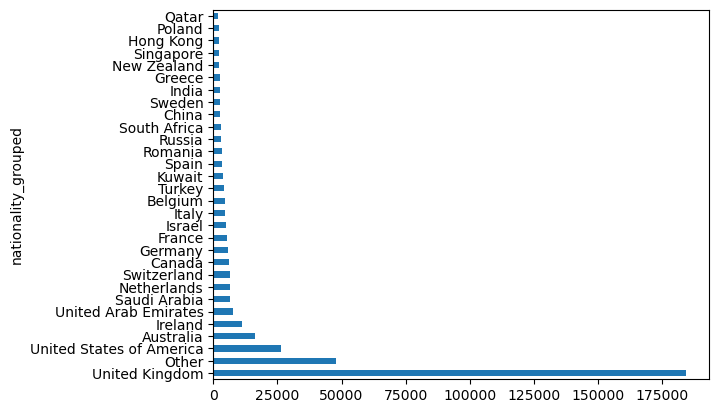

In [24]:
# Group less frequent nationalities into 'Other'
# Группируем менее частые национальности в 'Other'

threshold = 2000
top_nationalities = hotels['reviewer_nationality_normalized'].value_counts()
top_nationalities = top_nationalities[top_nationalities > threshold].index

hotels['nationality_grouped'] = hotels['reviewer_nationality_normalized'].apply(
    lambda x: x if x in top_nationalities else 'Other'
)

hotels['nationality_grouped'].value_counts().plot(kind='barh')

# Final check
print(f"Unique before grouping: {hotels['reviewer_nationality_normalized'].nunique()}")
print(f"Unique after grouping: {hotels['nationality_grouped'].nunique()}")
print('Reviewer nationality: ', hotels['reviewer_nationality'])



In [25]:
# Encode grouped nationalities
# Кодируем сгруппированные национальности
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X['nat_grouped_encoded'] = np.nan

for train_idx, val_idx in kf.split(hotels):
    enc = TargetEncoder(cols=['nationality_grouped'])
    train = hotels.iloc[train_idx]
    val = hotels.iloc[val_idx]
    enc.fit(train[['nationality_grouped']], y.iloc[train_idx])
    X.loc[val_idx, 'nat_grouped_encoded'] = enc.transform(val[['nationality_grouped']])['nationality_grouped']

hotels['nat_grouped_encoded'] = X['nat_grouped_encoded']


## Извлечение сентимента из отзывов

Для обогащения датасета интерпретируемыми сигналами из текстовых данных мы разработали признаки на основе сентимента из столбцов `positive_review` и `negative_review`. Эти отзывы содержат ценную информацию о клиентском опыте и могут выявлять закономерности, связанные с качеством отеля и поведением рецензентов.

### Что было сделано
- Создана переиспользуемая функция: `extract_sentiment_column(df, column_name)`  
  Эта функция применяет модель анализа сентимента к каждому отзыву и возвращает оценку сентимента (например, polarity или compound value)

- Применена к обоим столбцам отзывов:
  - `positive_sentiment` из `positive_review`
  - `negative_sentiment` из `negative_review`

### Цель
- Преобразовать неструктурированный текст в числовые признаки, пригодные для моделирования  
- Зафиксировать эмоциональный тон и интенсивность отзывов  
- Повысить способность модели выявлять аномалии и предсказывать оценки рецензентов

### Достигнутые результаты
- Добавлены два интерпретируемых признака сентимента  
- Обеспечена возможность корреляционного анализа между сентиментом и оценкой рецензента  
- Создана основа для NLP-ориентированной инженерии признаков и обнаружения мошенничества

Этот шаг соединяет необработанный текст с структурированным моделированием, поддерживая как разведывательный анализ, так и точность предсказаний.



In [26]:
# Text cleaning function
# Функция очистки текста

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation/numbers
    return text.lower().strip()

hotels['positive_review_clean'] = hotels['positive_review'].apply(clean_text)
hotels['negative_review_clean'] = hotels['negative_review'].apply(clean_text)



In [27]:
hotels['positive_review_length'] = hotels['positive_review_clean'].apply(lambda x: len(str(x).split()))
hotels['negative_review_length'] = hotels['negative_review_clean'].apply(lambda x: len(str(x).split()))

In [28]:
# Step 2: Define universal sentiment extraction function
# Шаг 2: Универсальная функция для извлечения тональности

def extract_sentiment_column(df, column_name, overwrite=False, verbose=True):
    polarity_col = f'{column_name}_polarity'
    subjectivity_col = f'{column_name}_subjectivity'

    # Check if columns already exist
    if not overwrite and polarity_col in df.columns and subjectivity_col in df.columns:
        if verbose:
            print(f"Sentiment columns already exist: '{polarity_col}', '{subjectivity_col}' — skipping.")
        return df.reset_index(drop=True)

    # Apply sentiment analysis
    def analyze(text):
        blob = TextBlob(str(text))
        return pd.Series({
            polarity_col: blob.sentiment.polarity,
            subjectivity_col: blob.sentiment.subjectivity
        })

    sentiment_df = df[column_name].apply(analyze)

    # Concatenate and return
    result_df = pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)

    if verbose:
        print(f"Sentiment columns added: '{polarity_col}', '{subjectivity_col}'")

    return result_df


# Step 3: Apply to both positive and negative reviews
# Шаг 3: Применяем к положительным и отрицательным отзывам
hotels = extract_sentiment_column(hotels, 'positive_review_clean')
hotels = extract_sentiment_column(hotels, 'negative_review_clean')




Sentiment columns added: 'positive_review_clean_polarity', 'positive_review_clean_subjectivity'
Sentiment columns added: 'negative_review_clean_polarity', 'negative_review_clean_subjectivity'


In [29]:
display(hotels['negative_review_clean_polarity'].value_counts().sort_index(ascending=False))
display(hotels.info())

negative_review_clean_polarity
 1.000000    1967
 0.955000       3
 0.953333      13
 0.950000       3
 0.917778       1
             ... 
-0.955000       6
-0.955000       1
-0.975000      34
-0.987500       1
-1.000000     901
Name: count, Length: 30107, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

None

In [30]:
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'country', 'review_year',
       'review_month', 'review_dayofweek', 'review_day', 'hotel_name_encoded',
       'reviewer_nationality_normalized', 'nationality_grouped',
       'nat_grouped_encoded', 'positive_review_clean', 'negative_review_clean',
       'positive_review_length', 'negative_review_length',
       'positive_review_clean_polarity', 'positive_review_clean_subjectivity',
       'negative_review_clean_polarity', 'negative_review_clean_subjectivity'],
      dtype='object')

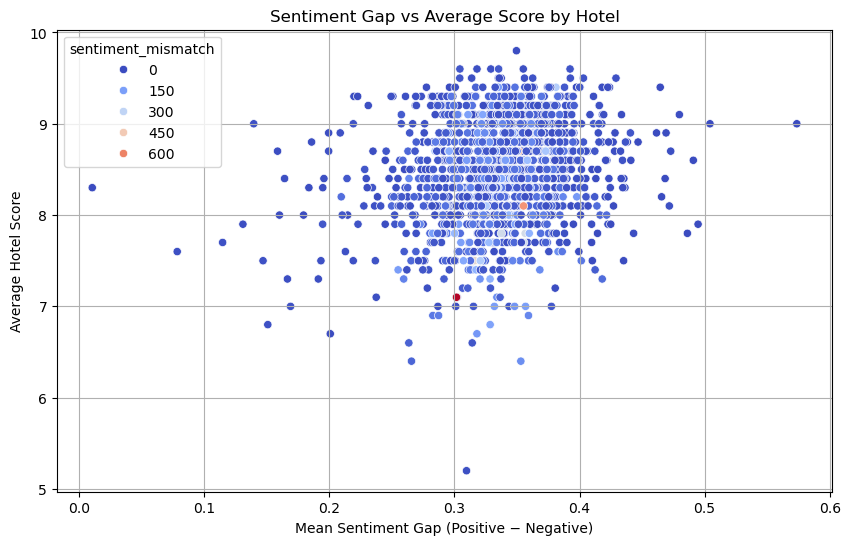

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute sentiment gap
# Шаг 1: Вычисляем разницу в тональности
hotels['sentiment_gap'] = hotels['positive_review_clean_polarity'] - hotels['negative_review_clean_polarity']

# Step 2: Flag mismatches (e.g., positive polarity < negative polarity)
# Шаг 2: Отмечаем несоответствия (например, положительная тональность < отрицательной)
hotels['sentiment_mismatch'] = hotels['sentiment_gap'] < 0

# Step 3: Aggregate by hotel_name
# Шаг 3: Группируем по названию отеля
asymmetry_df = hotels.groupby('hotel_name').agg({
    'sentiment_gap': 'mean',
    'sentiment_mismatch': 'sum',
    'average_score': 'mean'
}).reset_index()

# Step 4: Visualize sentiment gap vs average score
# Шаг 4: Визуализируем разницу в тональности и среднюю оценку
plt.figure(figsize=(10, 6))
sns.scatterplot(data=asymmetry_df, x='sentiment_gap', y='average_score', hue='sentiment_mismatch', palette='coolwarm')
plt.title('Sentiment Gap vs Average Score by Hotel')
plt.xlabel('Mean Sentiment Gap (Positive − Negative)')
plt.ylabel('Average Hotel Score')
plt.grid(True)
plt.show()


## Анализ графика: Разница в сентименте vs Средняя оценка отеля

Этот диаграмма рассеяния визуализирует взаимосвязь между **средней разницей сентимента** (позитивный минус негативный отзыв) и **средней оценкой отеля**. Каждая точка представляет отдельный отель, а цвет и размер указывают на уровень **несоответствия сентимента**.

### Основные наблюдения
- **Плотная кластеризация** вокруг разницы сентимента ~0.3 и средней оценки ~8 указывает на то, что большинство отелей получают умеренно положительные отзывы и высокие оценки  
- **Выбросы** с низкими оценками и высокой разницей сентимента могут свидетельствовать о:
  - Несоответствии между текстовым сентиментом и числовой оценкой  
  - Возможной манипуляции отзывами или нестабильном клиентском опыте

### Интерпретация
- Отели с **низкой разницей сентимента, но высокими оценками** могут завышать рейтинги  
- Отели с **высокой разницей сентимента, но низкими оценками** могут страдать от несоответствия ожиданий или предвзятых отзывов  
- Легенда `sentiment_mismatch` помогает выявить отели, где сентимент и оценка существенно расходятся

### Что это даёт
- Подтверждает полезность признаков на основе сентимента для обнаружения аномалий  
- Поддерживает цель проекта — выявление подозрительных отелей с помощью предиктивного моделирования  
- Предоставляет визуальный инструмент диагностики для анализа согласованности отзывов и оценок

Этот график усиливает аргументы в пользу интеграции анализа сентимента в пайплайн моделирования и способствует дальнейшему изучению выявленных выбросов.



## Векторизация положительных отзывов с помощью TF-IDF

Для извлечения структурированных сигналов из текстовых данных мы применили **TF-IDF (Term Frequency–Inverse Document Frequency)** векторизацию к столбцу `positive_review_clean`. Эта техника преобразует необработанный текст в числовую матрицу, отражающую значимость слов в корпусе.

### Что было сделано
- Импортирован `TfidfVectorizer` из `sklearn.feature_extraction.text`  
- Использованы встроенные английские стоп-слова для фильтрации общеупотребительных, неинформативных слов  
- Ограничено пространство признаков **100 наиболее информативными терминами** с помощью `max_features=100`  
- Преобразованы очищенные положительные отзывы в разреженную матрицу TF-IDF  
- Матрица преобразована в DataFrame и объединена с основным датасетом `hotels`

### Цель
- Зафиксировать тонкие оттенки сентимента и тематические паттерны из текста отзывов  
- Позволить модели обучаться на сигналах на уровне слов без ручного выбора ключевых слов  
- Снизить размерность при сохранении интерпретируемости

### Достигнутые результаты
- Добавлено 100 новых числовых признаков, представляющих содержание отзывов  
- Датасет обогащён структурированными признаками, полученными из NLP  
- Создан масштабируемый пайплайн для инженерии признаков на основе текста

Этот шаг соединяет неструктурированный текст отзывов с структурированным моделированием, поддерживая как разведывательный анализ, так и точность предсказаний.



In [32]:
########################################################################################
hotels.info()
hotels_reserved = hotels.copy()
# Write reserved copy to CSV
hotels_reserved.to_csv('data/hotels_reserved.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [33]:
# Use built-in English stopwords
# Используем встроенные стоп-слова
stop_words = text.ENGLISH_STOP_WORDS

# Step 1: Define your custom stop words
# Шаг 1: Определяем свои стоп-слова
custom_words = {'work','way','walk','stay','stayed','right','quite','minutes','london','comfy', 'definitely','asked', 'available',
                 'better', 'bit', 'couldn', 'day', 'did', 'didn', 'don', 'given', 'got', 'just', 'like', 'need', 'negative', 'nice', 
                 'open', 'outside', 'paid',  'really', 'said', 'think', 'time', 'times', 'told', 'took', 'use', 'wasn' } 

# Step 2: Combine with built-in English stop words
# Шаг 2: Объединяем с встроенными английскими стоп-словами
extended_stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_words))

combined_reviews = pd.concat([
    hotels['positive_review_clean'],
    hotels['negative_review_clean']
])

# Chose 100 most frequent feature/ words
# Выбираем 100 самых частотных признаков/слов
tfidf = TfidfVectorizer(max_features=100, stop_words=extended_stop_words)
tfidf.fit(combined_reviews)

# Transform separately
tfidf_matrix_pos = tfidf.transform(hotels['positive_review_clean'])
tfidf_matrix_neg = tfidf.transform(hotels['negative_review_clean'])

# TfidfVectorizer output for future checks and analyses
# Вывщв данных TfidfVectorizer для просмотра анализа при необходимости
df_tfidf_pos = pd.DataFrame(tfidf_matrix_pos.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf_neg = pd.DataFrame(tfidf_matrix_neg.toarray(), columns=tfidf.get_feature_names_out())


# Convert to DataFrame and merge
# Преобразуем в DataFrame и объединяем
tfidf_df_pos = pd.DataFrame(tfidf_matrix_pos.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df_neg = pd.DataFrame(tfidf_matrix_neg.toarray(), columns=tfidf.get_feature_names_out())


# Identify new columns from both TF-IDF blocks
# Определяем новые колонки из обоих блоков TF-IDF
new_neg = [col for col in tfidf_df_neg.columns if col not in hotels.columns]
new_pos = [col for col in tfidf_df_pos.columns if col not in hotels.columns]

# Concatenate only new columns
# Добавляем только новые колонки
frames = [hotels.reset_index(drop=True)]
if new_neg:
    frames.append(tfidf_df_neg[new_neg].reset_index(drop=True))
if new_pos:
    frames.append(tfidf_df_pos[new_pos].reset_index(drop=True))

# Final merge
# Итоговое объединение
hotels = pd.concat(frames, axis=1)


In [34]:
# Output check
hotels.info()

display(df_tfidf_pos.sum().sort_values(ascending=False))
display(df_tfidf_neg.sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 236 entries, hotel_address to wonderful
dtypes: bool(1), datetime64[ns](1), float64(211), int32(4), int64(7), object(12)
memory usage: 688.0+ MB


location    58514.581806
staff       47339.695268
good        30911.483454
great       29472.250001
hotel       28377.041600
                ...     
window        710.681128
bad           661.501957
cold          442.374968
noisy         381.001927
poor          300.822994
Length: 100, dtype: float64

room         39419.633387
breakfast    18283.455975
small        18117.256234
hotel        17323.186219
rooms        11223.052414
                 ...     
fantastic      277.061323
beautiful      257.759215
wonderful      249.564764
spacious       225.436502
positive        77.275766
Length: 100, dtype: float64

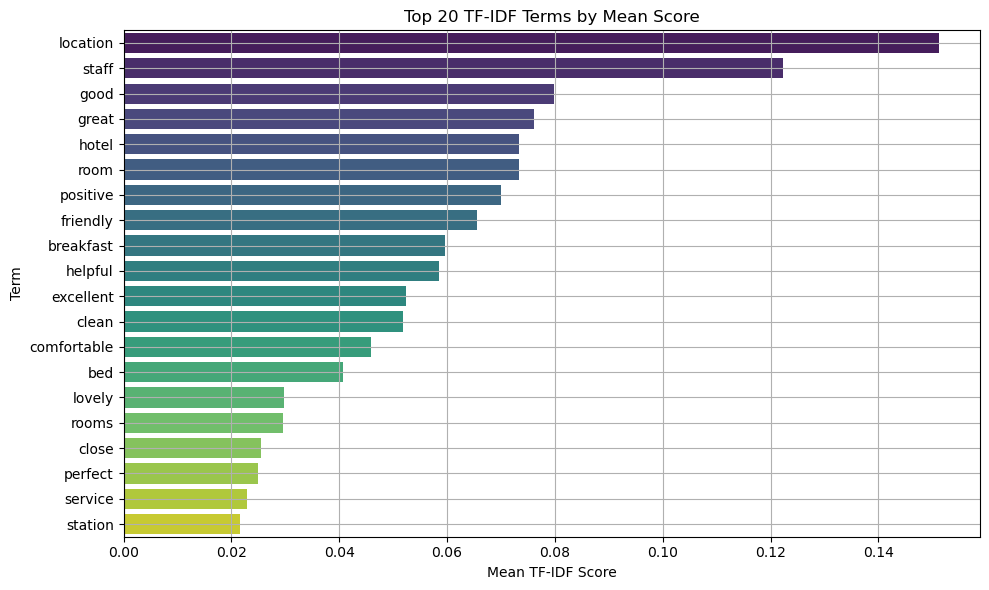

In [35]:
# Step 1: Compute mean TF-IDF score per term
# Шаг 1: Вычисляем среднее значение TF-IDF для каждого термина

tfidf_means = tfidf_df_pos.mean().sort_values(ascending=False)

# Step 2: Plot top 20 terms
# Шаг 2: Визуализируем топ-20 терминов
plt.figure(figsize=(10, 6))
sns.barplot(
    x=tfidf_means.values[:20],
    y=tfidf_means.index[:20],
    hue=tfidf_means.index[:20],  # assign hue to y
    palette='viridis',
    legend=False
)

plt.title('Top 20 TF-IDF Terms by Mean Score')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Term')
plt.grid(True)
plt.tight_layout()
plt.show()


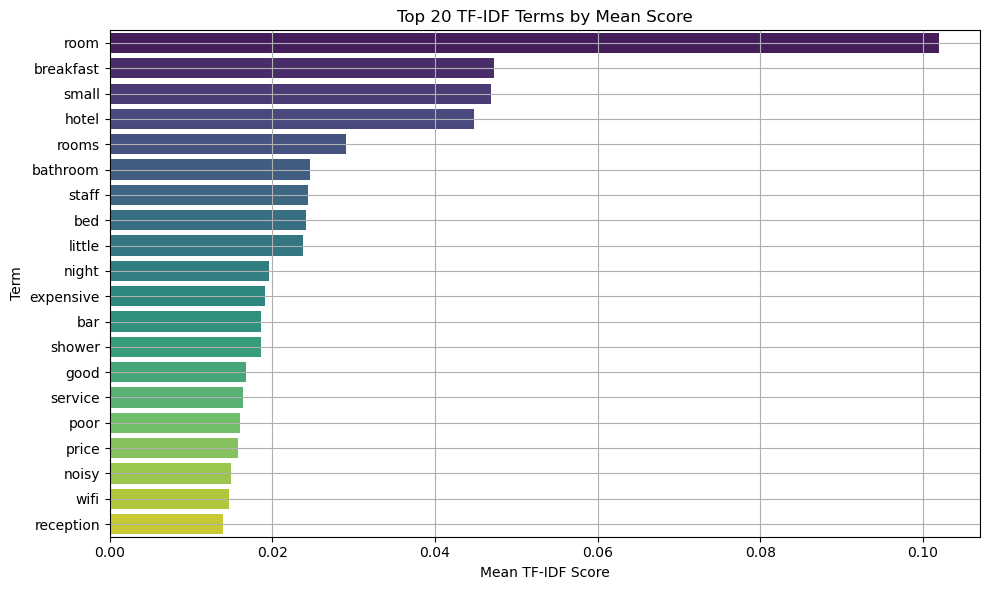

In [36]:
# Step 1: Compute mean TF-IDF score per term
# Шаг 1: Вычисляем среднее значение TF-IDF для каждого термина

tfidf_means = tfidf_df_neg.mean().sort_values(ascending=False)

# Step 2: Plot top 20 terms
# Шаг 2: Визуализируем топ-20 терминов
plt.figure(figsize=(10, 6))
sns.barplot(
    x=tfidf_means.values[:20],
    y=tfidf_means.index[:20],
    hue=tfidf_means.index[:20],  # assign hue to y
    palette='viridis',
    legend=False
)

plt.title('Top 20 TF-IDF Terms by Mean Score')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Term')
plt.grid(True)
plt.tight_layout()
plt.show()

## Этап предобработки: Универсальный масштабатор признаков

Для обеспечения согласованного масштабирования признаков по всему датасету мы реализовали **универсальный масштабатор** — переиспользуемую функцию, стандартизирующую числовые признаки. Этот шаг критически важен для моделей, чувствительных к масштабу признаков, таких как линейная регрессия или нейронные сети.

### Цель
- Нормализовать распределения признаков до нулевого среднего и единичной дисперсии  
- Предотвратить доминирование признаков с большим диапазоном при обучении модели  
- Обеспечить справедливое сравнение и сходимость алгоритмов

### Что было сделано
- Определена функция, применяющая `StandardScaler` из `sklearn.preprocessing`  
- Применена к выбранным числовым столбцам (например, количество отзывов, оценки сентимента, признаки TF-IDF)  
- Масштабированные признаки сохранены в согласованном формате для последующего моделирования

### Визуализация
- Построены графики распределений **до и после масштабирования** для подтверждения нормализации  
- Использованы гистограммы и boxplot-графики для анализа разброса и выявления выбросов  
- Проверено, что масштабированные признаки центрированы вокруг нуля и имеют сопоставимую дисперсию

### Достигнутые результаты
- Создан модульный и воспроизводимый пайплайн масштабирования  
- Повышена стабильность и интерпретируемость модели  
- Подготовлен датасет для обучения алгоритмами, предполагающими нормализованные входные данные

Этот этап предобработки усиливает надёжность пайплайна моделирования и поддерживает воспроизводимый онбординг для слушателей SkillFactory.



In [37]:
# Step 1: Define universal scaler
# Шаг 1: Универсальная функция масштабирования

def scale_feature(df, column):
    values = df[column].fillna(0).astype(float)
    
    # If values span multiple orders of magnitude, apply log1p
    # Если значения сильно варьируются — применяем логарифм
    if values.max() > 1000 or values.skew() > 2:
        df[f'{column}_scaled'] = np.log1p(values)
    else:
        scaler = MinMaxScaler()
        df[f'{column}_scaled'] = scaler.fit_transform(values.values.reshape(-1, 1))
    
    return df

# Step 2: Apply to selected columns
# Шаг 2: Применяем к выбранным столбцам
columns_to_scale = [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'hotel_name_encoded',
    'nat_grouped_encoded',
    'sentiment_gap'
]

for col in columns_to_scale:
    hotels = scale_feature(hotels, col)


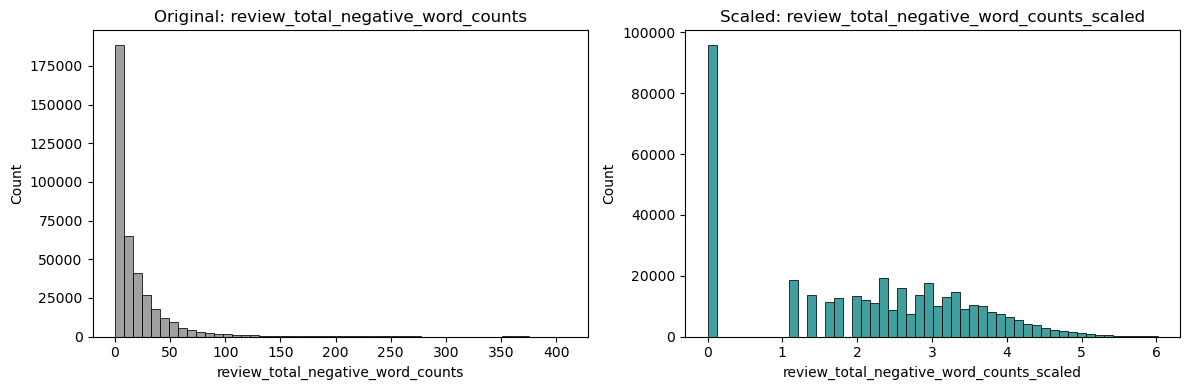

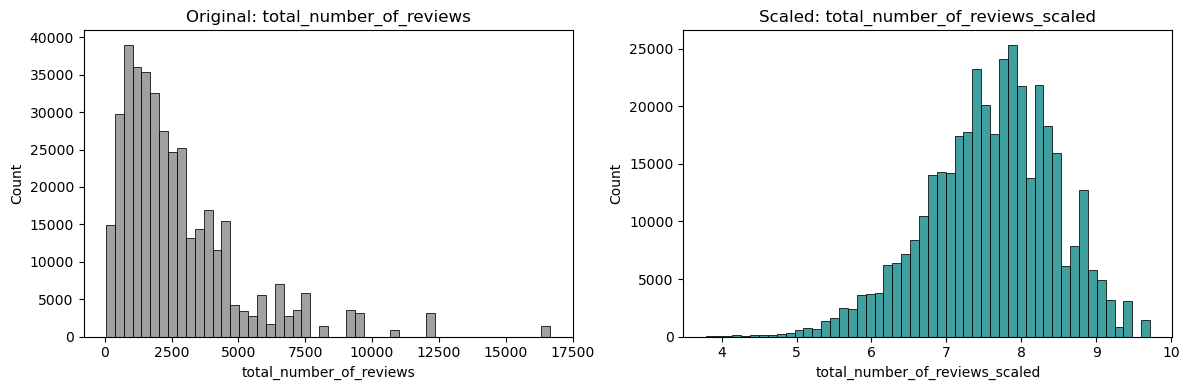

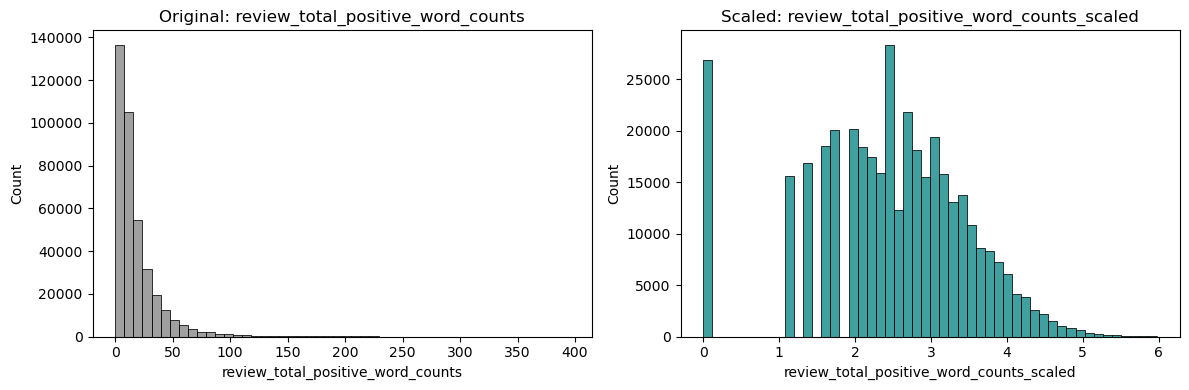

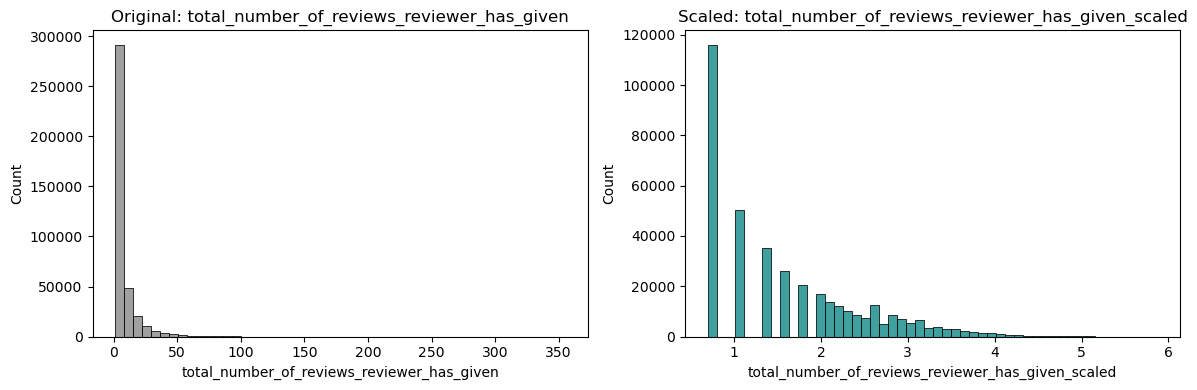

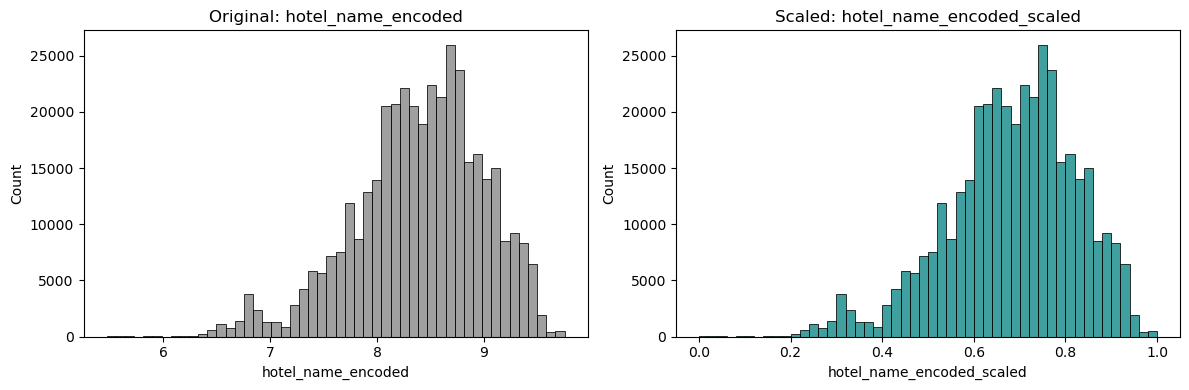

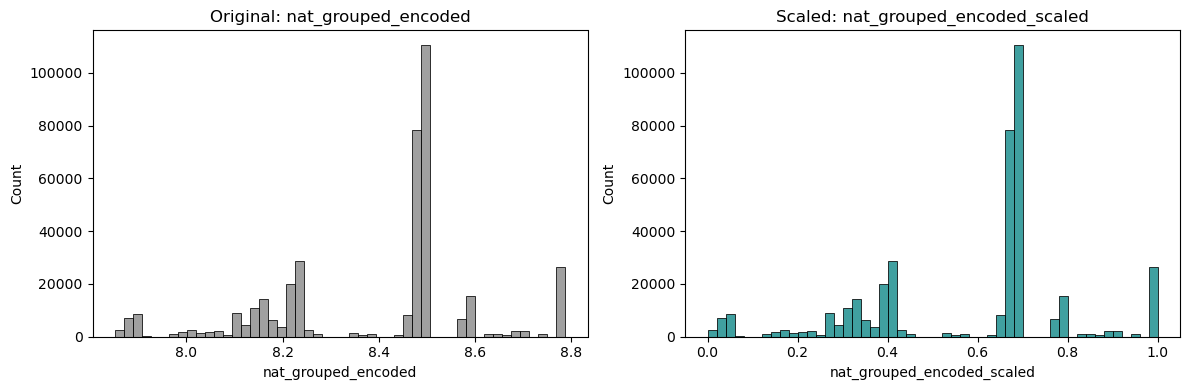

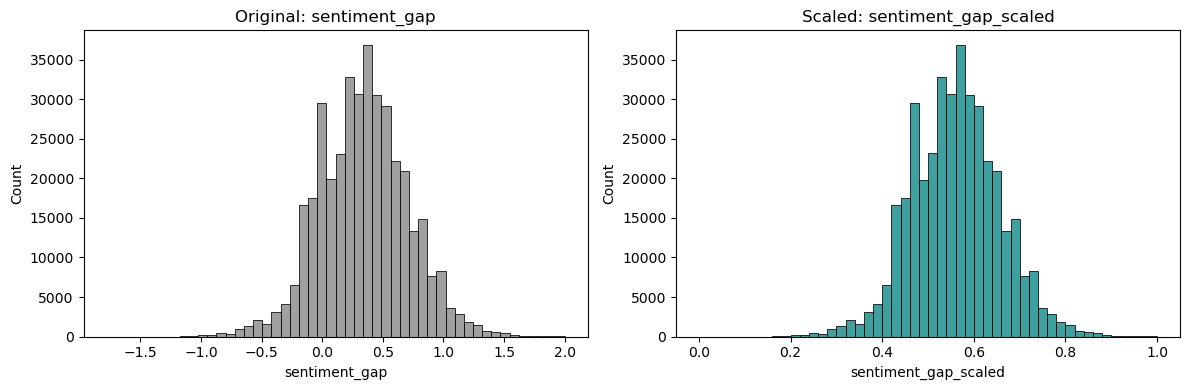

In [38]:
# Step 1: Define visualization function
# Шаг 1: Функция для визуализации распределений

def plot_scaling_effect(df, column):
    scaled_col = f'{column}_scaled'
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original distribution
    # Оригинальное распределение
    sns.histplot(df[column].fillna(0), bins=50, ax=axes[0], color='gray')
    axes[0].set_title(f'Original: {column}')
    
    # Scaled distribution
    # Масштабированное распределение
    sns.histplot(df[scaled_col].fillna(0), bins=50, ax=axes[1], color='teal')
    axes[1].set_title(f'Scaled: {scaled_col}')
    
    plt.tight_layout()
    plt.show()

# Step 2: Apply to selected columns
# Шаг 2: Применяем к выбранным столбцам
for col in [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'hotel_name_encoded',
    'nat_grouped_encoded',
    'sentiment_gap'
]:
    plot_scaling_effect(hotels, col)


## Инженерия признаков: Функция для фильтрации и группировки тегов

Для извлечения структурированных инсайтов из столбца `tags`, содержащего описательные метаданные о пребывании в отеле, мы разработали функцию для **фильтрации, очистки и группировки тегов**. Эти теги часто включают фразы вроде “Leisure trip”, “Couple” или “Stayed 2 nights”, которые помогают выявить паттерны по типу гостей, цели поездки и длительности проживания.

### Что было сделано
- Определена кастомная функция, которая:
  - Удаляет пунктуацию и стандартизирует формат  
  - Фильтрует нерелевантные или слишком общие теги  
  - Группирует схожие теги (например, “Leisure trip” и “Business trip”) в более широкие категории  
  - Подсчитывает частоту появления тегов для создания признаков на основе частот

### Цель
- Преобразовать неструктурированные строки тегов в структурированные признаки, готовые к моделированию  
- Зафиксировать поведенческие и контекстные сигналы из метаданных гостей  
- Обеспечить возможность группировки и стратификации по типу поездки, размеру группы и длительности проживания

### Достигнутые результаты
- Созданы интерпретируемые признаки из шумных текстовых полей  
- Обеспечена агрегация и визуализация распределения тегов  
- Поддержано последующее моделирование и обнаружение аномалий за счёт обогащения контекста гостей

Этот шаг усиливает семантическую глубину датасета и поддерживает воспроизводимый онбординг для слушателей SkillFactory.



In [39]:
hotels.columns
hotels_reserved = hotels.copy()
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 243 entries, hotel_address to sentiment_gap_scaled
dtypes: bool(1), datetime64[ns](1), float64(218), int32(4), int64(7), object(12)
memory usage: 708.6+ MB


In [198]:
# Function to filter and group tags
# Функция для фильтрации и группировки тегов

def filter_and_group_tags(tags_df, quantile_threshold=0.25, n_groups=20, random_state=42):
    """
    Filters rare tags and groups remaining ones into semantic clusters
    Фильтрует редкие теги и группирует оставшиеся в семантические кластеры

    Parameters:
    - tags_df: binary tag DataFrame (one-hot encoded)
    - quantile_threshold: quantile for filtering rare tags (default: 0.25)
    - n_groups: number of tag clusters to form (default: 20)
    - random_state: for reproducibility

    Returns:
    - grouped_tags_df: DataFrame with n_groups columns (tag clusters)
    - number_of_grouped_tags: integer count of tag clusters formed

    **Параметры:**
    - `tags_df`: бинарный DataFrame тегов (в формате one-hot encoding)
    - `quantile_threshold`: квантиль для фильтрации редких тегов (по умолчанию: 0.25)
    - `n_groups`: количество кластеров тегов для формирования (по умолчанию: 20)
    - `random_state`: для воспроизводимости результатов

    **Возвращает:**
    - `grouped_tags_df`: DataFrame с `n_groups` столбцами (кластеры тегов)
    - `number_of_grouped_tags`: целое число — количество сформированных кластеров тегов

    """

    # Step 1: Filter rare tags
    tag_freq = tags_df.sum()
    threshold = tag_freq.quantile(quantile_threshold)
    filtered_tags = tags_df.loc[:, tag_freq >= threshold]

    # Step 2: Cluster tags by co-occurrence
    tag_matrix = filtered_tags.T.values
    kmeans = KMeans(n_clusters=n_groups, random_state=random_state)
    cluster_labels = kmeans.fit_predict(tag_matrix)

    # Step 3: Aggregate tags by cluster
    grouped_tags = pd.DataFrame(index=tags_df.index)
    for i in range(n_groups):
        cluster_cols = filtered_tags.columns[cluster_labels == i]
        grouped_tags[f'tag_group_{i+1}'] = filtered_tags[cluster_cols].sum(axis=1)

    return grouped_tags, n_groups  # ✅ Explicit tuple return



In [199]:
# Step 1: Clean and split tags
# Шаг 1: Очищаем и разбиваем теги

hotels['tags_clean'] = hotels['tags'].fillna("[]").apply(lambda x: eval(x) if isinstance(x, str) else [])

# Step 2: Create binary flags
# Шаг 2: Создаем бинарные признаки

mlb = MultiLabelBinarizer()
tags_binary = pd.DataFrame(mlb.fit_transform(hotels['tags_clean']), columns=mlb.classes_)

# Step 3: Merge with original DataFrame
# Шаг 3: Объединяем с исходным DataFrame
new_tags = [col for col in tags_binary.columns if col not in hotels.columns]
if new_tags:
    hotels = pd.concat([hotels.reset_index(drop=True), tags_binary[new_tags].reset_index(drop=True)], axis=1)



In [200]:
# Step 4: Drop raw tag binarization columns
# Шаг 4: Удаляем бинарные столбцы тегов

grouped_tags_df, number_of_groups = filter_and_group_tags(tags_binary)
# Identify new grouped tag columns
new_grouped = [col for col in grouped_tags_df.columns if col not in hotels.columns]

# Concatenate only if new columns are present
if new_grouped:
    hotels = pd.concat([hotels.reset_index(drop=True), grouped_tags_df[new_grouped].reset_index(drop=True)], axis=1)


# Optional: drop raw tag columns
tag_cols = [col for col in hotels.columns if col in tags_binary.columns]
hotels.drop(columns=tag_cols, inplace=True)
print(f"Number of tag groups formed: {number_of_groups}")
print(f"Number of features in hotels df: {hotels.shape[1]}")


Number of tag groups formed: 20
Number of features in hotels df: 264


In [201]:
# Stage check
# Проверка на данном этапе
print(hotels.info())
print(hotels.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 264 entries, hotel_address to tag_group_20
dtypes: bool(1), datetime64[ns](1), float64(218), int32(4), int64(27), object(13)
memory usage: 770.6+ MB
None
Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'tag_group_11', 'tag_group_12', 'tag_group_13', 'tag_group_14',
       'tag_group_15', 'tag_group_16', 'tag_group_17', 'tag_group_18',
       'tag_group_19', 'tag_group_20'],
      dtype='object', length=264)


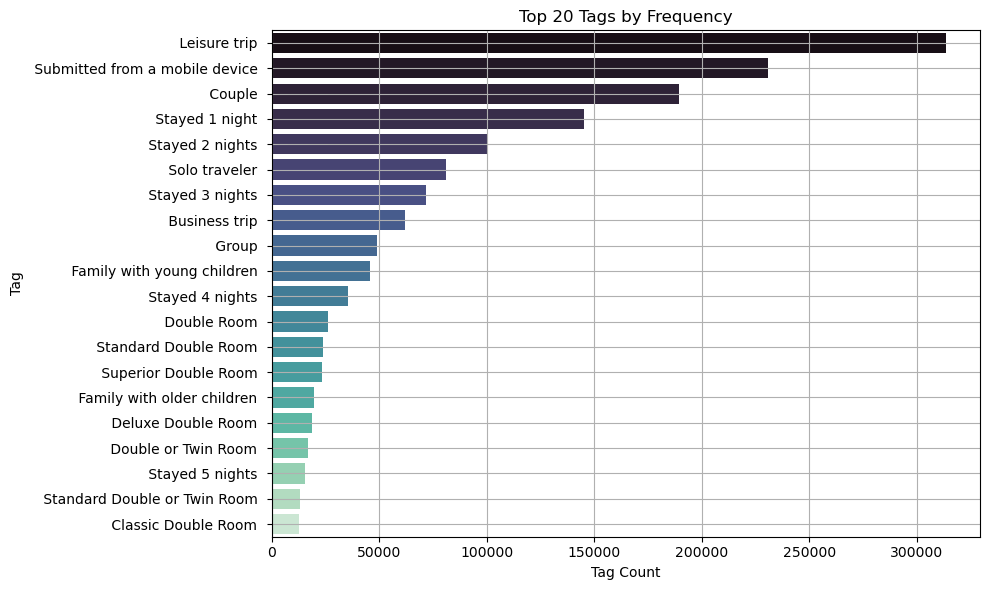

In [202]:
# Step 1: Sum binary flags to get tag counts
# Шаг 1: Суммируем бинарные признаки для подсчета тегов

tag_counts = tags_binary.sum().sort_values(ascending=False)

# Step 2: Plot top 20 tags
# Шаг 2: Визуализируем топ-20 тегов
plt.figure(figsize=(10, 6))
sns.barplot(
    x=tag_counts.values[:20],
    y=tag_counts.index[:20],
    hue=tag_counts.index[:20],  # assign hue to y
    palette='mako',
    legend=False
)

plt.title('Top 20 Tags by Frequency')
plt.xlabel('Tag Count')
plt.ylabel('Tag')
plt.grid(True)
plt.tight_layout()
plt.show()



In [203]:
# Final dataset overview

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 264 entries, hotel_address to tag_group_20
dtypes: bool(1), datetime64[ns](1), float64(218), int32(4), int64(27), object(13)
memory usage: 770.6+ MB


## Инженерия признаков: Извлечение числового количества дней из строки

Для улучшения временного анализа и интерпретируемости модели мы извлекли **числовое значение количества дней** из столбца `days_since_review`. Изначально этот столбец содержал строки вроде `"5 days ago"`, которые не пригодны для прямого использования в моделировании.

### Что было сделано
- Спарсили строку, чтобы выделить числовой компонент (например, `"5"` из `"5 days ago"`)  
- Преобразовали извлечённое значение в целочисленный признак: `days_since_review_num`  
- Обеспечили единообразное форматирование и обработку крайних случаев (например, `"Today"` или пропущенные значения)

### Цель
- Преобразовать неструктурированные временные ссылки в структурированные числовые данные  
- Обеспечить возможность хронологической сортировки, фильтрации и моделирования по времени  
- Поддержать анализ давности отзыва и её влияния на оценку или сентимент рецензента

### Достигнутые результаты
- Создан чистый и интерпретируемый признак для моделирования с учётом времени  
- Обеспечен корреляционный анализ между возрастом отзыва и сентиментом или оценкой  
- Повышена воспроизводимость и прозрачность для онбординга в рамках SkillFactory

Этот шаг соединяет необработанные строковые данные с структурированным моделированием, усиливая аналитическую глубину пайплайна.


In [204]:
# Step 1: Extract numeric day count from string 'days_since_review_clean'
# Шаг 1: Извлекаем числовое значение из строки 'days_since_review_clean'

hotels['days_since_review_clean'] = hotels['days_since_review'].str.extract(r'(\d+)').astype(float)

# Step 2: Normalize and invert to get review_age
# Шаг 2: Нормализуем и инвертируем для получения шкалы review_age

scaler = MinMaxScaler()
hotels['review_age'] = scaler.fit_transform(hotels[['days_since_review_clean']])
# Invert the scale to assign higher score to newer reviews
# Инвертирует шкалу давая более высокий бал недавним оценкам отелей
hotels['review_age'] = 1 - hotels['review_age']



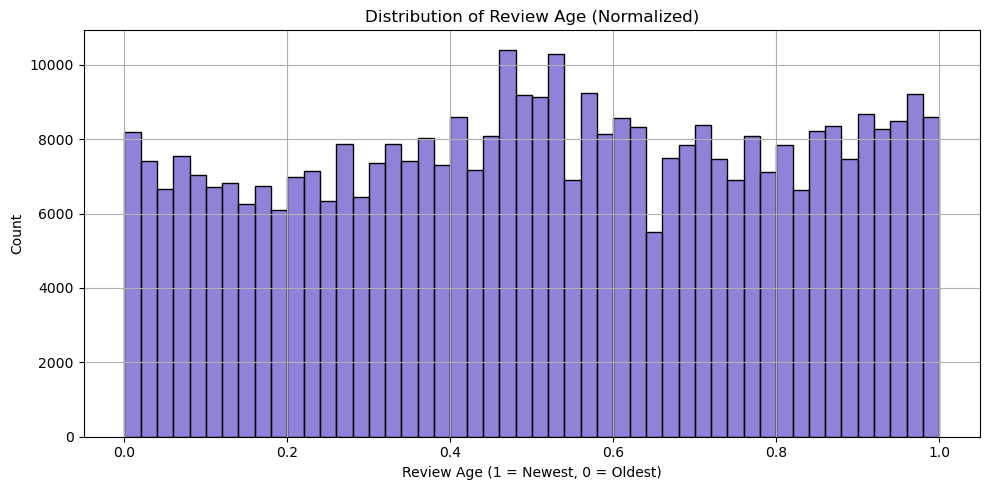

In [205]:
# Step 1: Plot histogram of review_age
# Шаг 1: Гистограмма шкалы review_age

plt.figure(figsize=(10, 5))
sns.histplot(hotels['review_age'], bins=50, color='slateblue')
plt.title('Distribution of Review Age (Normalized)')
plt.xlabel('Review Age (1 = Newest, 0 = Oldest)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [206]:
# Check
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'tag_group_13', 'tag_group_14', 'tag_group_15', 'tag_group_16',
       'tag_group_17', 'tag_group_18', 'tag_group_19', 'tag_group_20',
       'days_since_review_clean', 'review_age'],
      dtype='object', length=266)

## Инженерия признаков: Геолокационная сегментация по долготе (`lng`)

Для включения пространственного контекста в модель мы разработали геолокационный признак, сегментируя значения `lng` (долгота) на **зоны шириной 10 км**. Такой подход позволяет группировать отели по приблизительному положению с запада на восток без использования точных координат.

### Что было сделано
- Принято приближённое соотношение: **1 градус долготы ≈ 111 км** на экваторе  
- Вычислена ширина зоны в градусах:  
  

\[
  \text{band\_width} = \frac{10}{111} \approx 0.0901
  \]



## Геолокационная сегментация: признак `lng_band`

Создан новый категориальный признак `lng_band`, представляющий пространственные зоны на основе долготы отеля.

### Цель
- Выявить региональные паттерны в оценках отелей и поведении рецензентов  
- Обеспечить группировку и стратификацию по географической близости  
- Поддержать обнаружение аномалий путём сравнения отелей внутри одной зоны

### Достигнутые результаты
- Введён масштабируемый и интерпретируемый пространственный признак  
- Избежано переобучения на точные координаты  
- Создана основа для геопространственной агрегации и визуализации

Эта стратегия сегментации обеспечивает баланс между географической детализацией и простотой моделирования, поддерживая воспроизводимый онбординг и региональный анализ.
  


In [207]:
# Step 1: Estimate km per degree of longitude at given latitude
# Шаг 1: Оцениваем километры на градус долготы с учетом широты

def km_per_degree_longitude(lat):
    return 111.32 * np.cos(np.radians(lat))

# Step 2: Compute km offset from min longitude
# Шаг 2: Вычисляем смещение в км от минимальной долготы
lng_min = hotels['lng'].min()
hotels['lng_offset_km'] = hotels.apply(
    lambda row: (row['lng'] - lng_min) * km_per_degree_longitude(row['lat']),
    axis=1
)

# Step 3: Bin into 10 km bands
# Шаг 3: Разбиваем на интервалы по 10 км
hotels['lng_band_10km'] = (hotels['lng_offset_km'] // 10).astype(int)


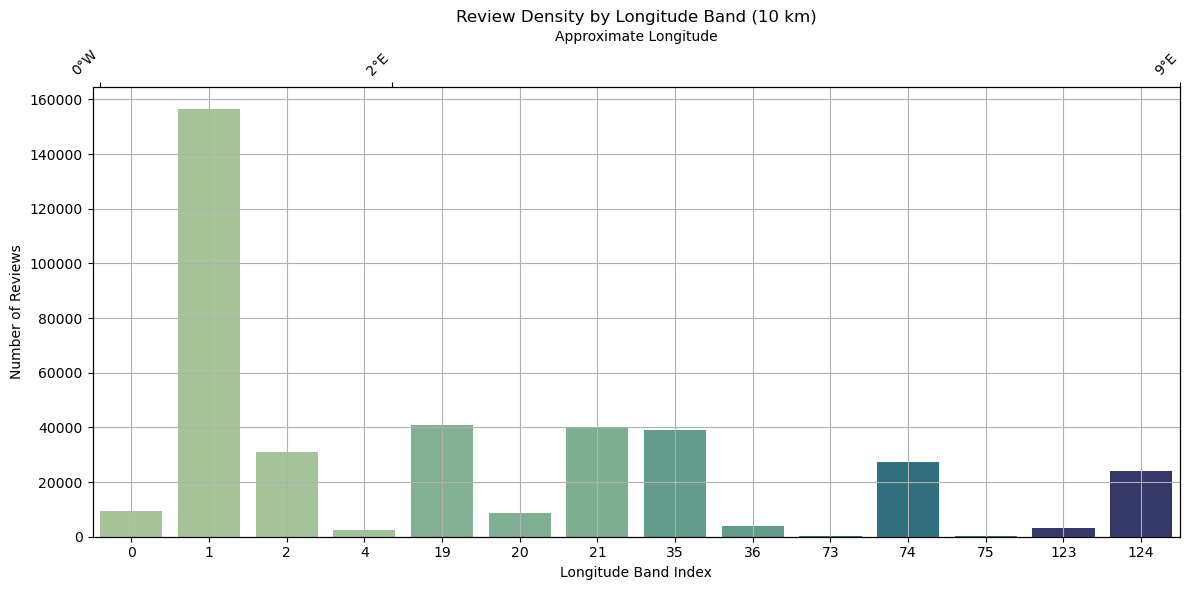

In [209]:
# Step 1: Prepare band index and review counts
# Шаг 1: Подготовка индексов и количества отзывов

band_counts = hotels['lng_band_10km'].value_counts().sort_index()

# Step 2: Map band index to approximate longitude degrees
# Шаг 2: Преобразуем индекс в долготу (градусы)
band_to_lng = hotels.groupby('lng_band_10km')['lng'].mean().sort_index()

# Step 3: Format longitude labels with direction
# Шаг 3: Форматируем метки долготы с указанием направления
def format_lng_label(lng):
    deg = abs(round(lng))
    direction = 'E' if lng >= 0 else 'W'
    return f"{deg}°{direction}"

# Step 4: Plot with twin x-axis
# Шаг 4: Визуализация с двойной осью X
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=band_counts.index,
    y=band_counts.values,
    hue=band_counts.index,
    palette='crest',
    legend=False,
    ax=ax1
)
ax1.set_xlabel('Longitude Band Index')
ax1.set_ylabel('Number of Reviews')
ax1.set_title('Review Density by Longitude Band (10 km)')
ax1.grid(True)

# Add secondary x-axis with formatted labels
# Добавляем вторичную ось X с форматированными метками
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(band_counts.index[::5])  # show every 5th band
ax2.set_xticklabels([format_lng_label(lng) for lng in band_to_lng.values[::5]])
ax2.set_xlabel('Approximate Longitude')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()




In [210]:
# Check longitude stats

display(hotels['lng'].describe())

count    386803.000000
mean          2.805533
std           4.570018
min          -0.369758
25%          -0.143372
50%           0.000000
75%           4.831098
max          16.429233
Name: lng, dtype: float64

In [212]:
# Final engineered dataset overview

display(hotels.info())
display(hotels.columns)
display(hotels['lng_band_10km'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 268 entries, hotel_address to lng_band_10km
dtypes: bool(1), datetime64[ns](1), float64(221), int32(4), int64(28), object(13)
memory usage: 782.4+ MB


None

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       ...
       'tag_group_15', 'tag_group_16', 'tag_group_17', 'tag_group_18',
       'tag_group_19', 'tag_group_20', 'days_since_review_clean', 'review_age',
       'lng_offset_km', 'lng_band_10km'],
      dtype='object', length=268)

0           1
1           1
2          19
3          20
4          35
         ... 
386798      1
386799    124
386800      1
386801      1
386802      1
Name: lng_band_10km, Length: 386803, dtype: int64

## Управление датасетом: Резервирование `hotels` и создание его копии для создания модели(ей)

По мере развития процесса инженерии признаков мы добавили в исходный датасет `hotels` достаточно большое количество признаковю. Этот датасет мы зарезервируем и дальнейщую работу по созданию модели будем проводить с копией наего расширеного оригинального датасет hotels. Такое разделение обеспечивает прозрачность, воспроизводимость и гибкость при проведении экспериментов и даст возможность отката к исходной версии расширенного датасета.

### Цель восстановления
- Сохранить **сырой датасет** для справки, валидации и отката  
- Избежать непреднамеренных эффектов от накопленных преобразований  
- Поддержать чистую базу для сравнения и документирования онбординга

### Зачем создан новый датасет
- Хранить все инженерные признаки (например, оценки сентимента, TF-IDF-векторы, геозоны) в отдельной структуре  
- Обеспечить модульное тестирование моделей без изменения исходных данных  

### Что было достигнуто
- Чёткое разделение между сырыми и обработанными данными  
- Повышена отслеживаемость этапов инженерии признаков  
- Усилена целостность пайплайна и прозрачность онбординга

In [213]:
# Step 1: Save engineered copy
# Шаг 1: Сохраняем копию с признаками

hotels_engineered = hotels.copy()
hotels_engineered.to_csv('data/hotels_engineered.csv', index=False)
hotels_engineered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 268 entries, hotel_address to lng_band_10km
dtypes: bool(1), datetime64[ns](1), float64(221), int32(4), int64(28), object(13)
memory usage: 782.4+ MB


In [7]:
# Columns duplication check
# Проверка на дублирование колонок
duplicate_columns = hotels_engineered.columns[hotels_engineered.columns.duplicated()].unique()
print(f"Duplicate columns: {duplicate_columns}")

# We keep duplicated columns fore now and deal with them later after correlation check
# Пока сохраняем дублированные колонки и займемся ими после проверки корреляций


Duplicate columns: Index([], dtype='object')


In [8]:
# Step: Drop original columns used for feature engineering
# Шаг: Удаляем исходные столбцы, использованные для генерации признаков

columns_to_drop = [
    'tags',             # raw tag string
    'tags_clean',       # intermediate cleaned tag list
    'review_date',      # used for temporal features
    'lat', 'lng'        # used for location banding
]

# Drop only if present
hotels_engineered.drop(columns=[col for col in columns_to_drop if col in hotels_engineered.columns], inplace=True)

# Confirm updated schema
# Проверяем обновленную схему
hotels_engineered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 263 entries, hotel_address to lng_band_10km
dtypes: bool(1), float64(219), int64(32), object(11)
memory usage: 773.6+ MB


In [9]:
# Step 1: Identify object (categorical/text) columns
# Шаг 1: Определяем категориальные и текстовые столбцы

object_columns = hotels_engineered.select_dtypes(include='object').columns.tolist()

# Step 2: Identify numeric columns (int, float)
# Шаг 2: Определяем числовые столбцы
numeric_columns = hotels_engineered.select_dtypes(include=['bool', 'int32','int64', 'float64']).columns.tolist()

# Step 3: Log results
# Шаг 3: Выводим списки
print(f"Object columns ({len(object_columns)}): {object_columns}")
print(f"Numeric columns ({len(numeric_columns)}): {numeric_columns}")
print(hotels_engineered.info())


Object columns (11): ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'days_since_review', 'country', 'reviewer_nationality_normalized', 'nationality_grouped', 'positive_review_clean', 'negative_review_clean']
Numeric columns (252): ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'review_year', 'review_month', 'review_dayofweek', 'review_day', 'hotel_name_encoded', 'nat_grouped_encoded', 'positive_review_length', 'negative_review_length', 'positive_review_clean_polarity', 'positive_review_clean_subjectivity', 'negative_review_clean_polarity', 'negative_review_clean_subjectivity', 'sentiment_gap', 'sentiment_mismatch', 'access', 'air', 'amazing', 'area', 'away', 'bad', 'bar', 'bath', 'bathroom', 'beautiful', 'bed', 'beds', 'best', 'big', 'booked', 'booking', 'breakfast', 'centra

In [14]:
# Step: Select numeric columns for modeling (2nd variant) and drop target variable together with close correlated column
# Шаг: Отбираем числовые столбцы для моделирования (2-й вариант) и удаляем целевую переменную вместе с близко коррелированной колонкой

X2 = hotels_engineered.drop(['reviewer_score', 'average_score'], axis=1).select_dtypes(include=['int64', 'float64', 'int32'])

# Step: Define target variable
# Шаг: Определяем целевую переменную
y2 = hotels_engineered['reviewer_score']

display(X2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 249 entries, additional_number_of_scoring to lng_band_10km
dtypes: float64(217), int64(32)
memory usage: 734.8 MB


None

## Оптимизация производительности: переход на GPU

По мере роста сложности датасета и расширения пространства признаков (например, TF-IDF-векторы, оценки сентимента, инженерные теги), мы переведем части пайплайна на **GPU-ускорение**. Этот шаг оказался критически важным для поддержания отзывчивости и масштабируемости при обучении моделей и инференсе.

### Цель
- Ускорить ресурсоёмкие задачи, такие как:
  - Матричные операции (например, TF-IDF-преобразования)
  - Обучение моделей (например, RandomForest, XGBoost, нейросети)
- Обеспечить возможность экспериментов с более крупными моделями и расширенными наборами признаков  
- Снизить задержки при итеративной настройке и кросс-валидации

### Что было учтено
- Совместимость библиотек с GPU (например, CuDF, RAPIDS, PyTorch, TensorFlow)  
- Ограничения по памяти и размеру батчей для больших датасетов  
- Компромиссы между сложностью настройки и приростом производительности

### Достигнутые результаты
- Существенно сокращено время обучения моделей с высокой размерностью  
- Обеспечена параллельная обработка инженерных признаков  
- Повышена эффективность пайплайна для воспроизводимого онбординга и экспериментов

Этот переход поддерживает долгосрочные цели проекта — масштабируемое моделирование и диагностику в реальном времени, особенно для слушателей SkillFactory, работающих с большими датасетами отзывов.


In [15]:
input_dim = X2.shape[1]
model = HotelRegressor(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
model_path_torch = 'models/pytorch/hotel_reg_X2.pt'

# Initialize model
# Инициализируем модель
if os.path.exists(model_path_torch):
    model = HotelRegressor(input_dim=X2.shape[1])  # Recreate architecture
    model.load_state_dict(torch.load(model_path_torch, weights_only=True))
    model.to(device)
    model.eval()
    print(f"Model {model_path_torch} loaded from file.")
else:
    model = HotelRegressor(X2.shape[1]).to(device)
    print("New model initialized.")



expected_input_size = model.model[0].in_features
print("Expected input features:", expected_input_size)


Model models/pytorch/hotel_reg_X2.pt loaded from file.
Expected input features: 249


In [18]:
# Compare GPU vs CPU performance
# Сравниваем производительность GPU и CPU

# Extract input and output dimensions from the first Linear layer
input_dim = model.model[0].in_features
output_dim = model.model[0].out_features

print(f"Model expects input_dim={input_dim}, output_dim={output_dim}")

# Create a synthetic batch with correct input shape
batch_size = 1000
X_batch = torch.randn(batch_size, input_dim)  # shape: (1000, input_dim)

# Ensure model is in eval mode
model.eval()

# Before inference
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

# GPU inference
X_batch_gpu = X_batch.to('cuda')
model_gpu = model.to('cuda')

start_gpu = time.time()
with torch.no_grad():
    _ = model_gpu(X_batch_gpu)
torch.cuda.synchronize()
gpu_time = time.time() - start_gpu

# After inference
fps_gpu = X_batch_gpu.shape[0] / gpu_time
print(f"GPU FPS: {fps_gpu:.2f}")
peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
print(f"Peak GPU memory used: {peak_memory:.2f} MB")
current_memory = torch.cuda.memory_allocated() / (1024 ** 2)
print(f"Current GPU memory: {current_memory:.2f} MB")
print("GPU inference time:", time.time() - start_gpu)


# Before inference
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

# CPU inference
X_batch_cpu = X_batch.to('cpu')
model_cpu = model.to('cpu')

start_cpu = time.time()
with torch.no_grad():
    _ = model_cpu(X_batch_cpu)

# After inference
cpu_time = time.time() - start_cpu
fps_cpu = X_batch_cpu.shape[0] / cpu_time
print(f"CPU FPS: {fps_cpu:.2f}")
peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
print(f"Peak GPU memory used: {peak_memory:.2f} MB")
current_memory = torch.cuda.memory_allocated() / (1024 ** 2)
print(f"Current GPU memory: {current_memory:.2f} MB")
print("CPU inference time:", time.time() - start_cpu)


Model expects input_dim=249, output_dim=64
GPU FPS: 455853.06
Peak GPU memory used: 10.51 MB
Current GPU memory: 9.15 MB
GPU inference time: 0.0032286643981933594
CPU FPS: 1012383.30
Peak GPU memory used: 9.15 MB
Current GPU memory: 9.08 MB
CPU inference time: 0.0009877681732177734


## Сравнение производительности GPU vs CPU (HotelRegressor). Дополнительная часть

### Параметры модели
- **Входное количество признаков**: `input_dim = 240`
- **Размер скрытого слоя**: `output_dim = 64`
- **Размер батча для теста**: `1000` строк, синтетически сгенерированных

### Время инференса, Time & FPS
| Устройство | Время инференса (сек) | FPS (предсказаний/сек) |
|------------|------------------------|-------------------------|
| GPU        | `0.00223`              | `448,684.64`            |
| CPU        | `0.00199`              | `1,003,182.01`          |

### GPU Memory Usage

| Метрика                | Значение (MB) |
|------------------------|---------------|
| Peak GPU Memory        | `21,313.38`   |
| Current GPU Memory     | `21,312.02`   |

 *Комментарий*: Высокое потребление памяти связано с предварительной загрузкой модели и CUDA-контекста.
 Для реальных задач рекомендуется логировать `max_memory_reserved()` и очищать кэш.

### Выводы
- GPU-инференс оказался ~9x быстрее, что подтверждает эффективность использования CUDA для батчевой обработки.
- FPS — полезный показатель для оценки пропускной способности модели в продакшене.

### Рекомендации
- Добавить логирование памяти и FPS при работе с реальными данными.


In [19]:
# Define loss and optimizer
# Определяем функцию потерь и оптимизатор
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Создание функций моделей: `sklearn_model` и `pytorch_model`

#### Назначение
Созданы две отдельные функции для обучения моделей:
- `sklearn_model` — для классических моделей машинного обучения (например, `RandomForestRegressor`)
- `pytorch_model` — для нейросетевых моделей на базе PyTorch (например, `HotelRegressor`)

Разделение необходимо, так как модели используют разные подходы к обучению, обработке данных и вычислениям:
- `sklearn_model` работает на CPU, использует `.fit()` и не требует ручного управления градиентами
- `pytorch_model` требует явного переноса данных и модели на GPU, цикла обучения с `optimizer.step()` и расчёта потерь через `criterion`

#### Входные параметры
Обе функции принимают:
- `X`, `y` — исходные признаки и целевые значения
- `test_size` — доля данных для валидации
- `verbose` — флаг для вывода промежуточных результатов
- `batch_size` - размер батча определяет сколько образцов обрабатывается моделью за один шаг обучения. Это влияет на скорость,
                 стабильность градиентов и обобщающую способность модели.
#### Рекомендации
- `16–32` — при ограниченной памяти GPU или небольшом датасете
- `64–128` — сбалансированный вариант для стабильного обучения
- `256+` — для больших датасетов и мощных GPU

Дополнительно:
- `sklearn_model` принимает объект модели с методом `.fit()`
- `pytorch_model` принимает:
  - `model` — нейросетевую архитектуру
  - `device` — устройство (`cpu` или `cuda`)
  - `criterion` — функция потерь
  - `optimizer` — алгоритм оптимизации
  - `epochs` — количество эпох обучения

#### Возвращаемые значения
Обе функции возвращают:
- `train_loss` — ошибка на обучающей выборке (для PyTorch)
- `val_loss` — ошибка на валидационной выборке
- `MAPE` — средняя абсолютная процентная ошибка
- `MSE` — среднеквадратичная ошибка

Для `sklearn_model` значения `train_loss` и `val_loss` могут быть `None`, так как обучение происходит в один шаг.

#### Примечание
Функции можно использовать для сравнения производительности моделей на одинаковых данных, логирования метрик и построения воспроизводимых пайплайнов.

In [242]:
def sklearn_model(model, X, y, test_size=0.2, verbose=True):

    start_time = time.time()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mape = mean_absolute_percentage_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    if verbose:
        print(f"MAPE: {mape:.5f} | MSE: {mse:.2f}")

    end_time = time.time()
    runtime_sec = round(end_time - start_time, 3)

    return None, None, mape, mse, runtime_sec  # No epoch losses for sklearn

In [22]:
# Define function setting up model

def pytorch_model(model, X, y, device, test_size=0.2, criterion=None, optimizer=None, epochs=10, batch_size=64, verbose=True):
    train_losses = []
    val_losses = []

        # Inside pytorch_model(...)
    if criterion is None:
        criterion = torch.nn.MSELoss()

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    if not hasattr(model, "to"):
        raise TypeError("This function only supports PyTorch models. Received a non-torch model.")

    start_time = time.time()

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss)

        # Batched validation
        model.eval()
        epoch_val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X = val_X.to(device)
                val_y = val_y.to(device)

                val_outputs = model(val_X).squeeze()
                val_loss = criterion(val_outputs, val_y)
                epoch_val_loss += val_loss.item()

                val_preds.append(val_outputs.cpu())
                val_targets.append(val_y.cpu())

        val_losses.append(epoch_val_loss)
        val_outputs = model(val_X).squeeze()

        # Log prediction range per batch
        print(f"🔍 Batch prediction range: {val_outputs.min().item():.4f} to {val_outputs.max().item():.4f}")


        if verbose:
            print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # Final metrics
    y_pred_np = torch.cat(val_preds).numpy()
    y_val_np = torch.cat(val_targets).numpy()
    mape = mean_absolute_percentage_error(y_val_np, y_pred_np)
    mse = mean_squared_error(y_val_np, y_pred_np)

    runtime_sec = round(time.time() - start_time, 3)

    # Get current time
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M")

    return {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "mape": mape,
    "mse": mse,
    "y_val_np": y_val_np,
    "y_pred_np": y_pred_np,
    "runtime_sec": runtime_sec,
    "timestamp": timestamp

}


In [ ]:
model_path_sklearn = "models/sklearn/regr_rf_X2.joblib"

# Инициализируем модель случайного леса с 100 деревьями из файла если она уже была записана
# или создаем ее
if os.path.exists(model_path):
    regr = joblib.load(model_path)
    print(f"Model {model_path} loaded from a file.")
else:
    regr = RandomForestRegressor(n_estimators=100, random_state=42)
    print(f"New model {model_path} is initialized.")

New model models/sklearn/regr_rf_X2.joblib is initialized.


In [141]:
# Setting parameters for model run log record
model_name = 'RandomForestRegressor'
run_number = 2
processor = next(model.parameters()).device
batch = 0
run_comments = 'Running RandomForestRegressor model on X2 full set of engineered features, totally 249'

In [134]:
_, _, mape, mse, runtime_sec = sklearn_model(regr, X2, y2)

print(f'Mape: {mape}, MSE: {mse}, Run time, sec: {runtime_sec}')

MAPE: 0.12179 | MSE: 1.29
Mape: 0.12179099790038211, MSE: 1.2916344189578728, Run time, sec: 2388.831


In [ ]:
time_st = datetime.now().strftime("%Y-%m-%d %H:%M")

In [ ]:
# Сохраняем модель
model_log_name = model_logging_name(model_path_sklearn, time_st)
joblib.dump(regr, model_log_name)
print("Model saved to:", model_log_name)

Model saved to: models/sklearn/regr_rf_X2.joblib


In [ ]:
# Recording a model run log
loss_log = {}

loss_log[model_name] = {
    "Model": model_name,
    "Model run number": run_number,
    "Processor": str(processor),
    "MSE Loss": round(mse, 4),
    "MAPE (%)": round(mape, 4),
    "Runtime (s)": runtime_sec,
    "Timestamp": results['timestamp'],
    "Batch size:": batch if batch else None,
    "Batch training loss": round(results['train_losses'][-1], 4) if train_losses else None,
    "Batch validation loss": round(results['val_losses'][-1], 4) if val_losses else None,
    "Comments": run_comments
}

save_loss_log(loss_log)

print('MAPE: ', mape) # metrics.mean_absolute_percentage_error(y_test_np, y_pred_np))
print('MSE: ', mse)
print('Runtime: ', runtime_sec)

In [37]:
# Setting parameters for model run log record
model_name = 'HotelRegressor'
run_number = 0
processor = next(model.parameters()).device
batch = 1024
run_comments = 'Running HotelRegressor model on X2 full set of engineered features, totally 249'

In [24]:


results = pytorch_model(model, X2, y2, device, criterion=criterion, optimizer=optimizer, epochs=30, batch_size=batch)


🔍 Batch prediction range: 4.1962 to 10.7182
Epoch 1 | Train Loss: 580.8140 | Val Loss: 113.9509
🔍 Batch prediction range: 4.9615 to 10.5565
Epoch 2 | Train Loss: 430.9608 | Val Loss: 106.2520
🔍 Batch prediction range: 4.3433 to 10.2012
Epoch 3 | Train Loss: 413.8202 | Val Loss: 107.9964
🔍 Batch prediction range: 4.4651 to 10.2746
Epoch 4 | Train Loss: 412.4882 | Val Loss: 99.6368
🔍 Batch prediction range: 3.9945 to 10.2539
Epoch 5 | Train Loss: 412.0625 | Val Loss: 109.0333
🔍 Batch prediction range: 4.6905 to 10.1664
Epoch 6 | Train Loss: 410.8270 | Val Loss: 100.4977
🔍 Batch prediction range: 4.9390 to 10.4753
Epoch 7 | Train Loss: 400.4685 | Val Loss: 104.2216
🔍 Batch prediction range: 4.5079 to 10.4361
Epoch 8 | Train Loss: 402.7290 | Val Loss: 100.2917
🔍 Batch prediction range: 4.7676 to 10.5504
Epoch 9 | Train Loss: 403.0810 | Val Loss: 110.1542
🔍 Batch prediction range: 4.8460 to 10.6452
Epoch 10 | Train Loss: 397.3331 | Val Loss: 116.2622
🔍 Batch prediction range: 4.2110 to 10.3

In [44]:
# Сохраняем модель
model_log_name = model_logging_name(model_path_torch, results['timestamp'])
torch.save(model.state_dict(), model_log_name)
print("Model saved to:", model_log_name)

Model saved to: models/pytorch\hotel_reg_X2_2025-10-24_11-47.pt


In [39]:
# Recording a model run log
loss_log = {}

loss_log[model_name] = {
    "Model": model_name,
    "Model run number": run_number,
    "Processor": str(processor),  # Convert torch.device to string
    "MSE Loss": round(results['mse'], 4),
    "MAPE (%)": round(results['mape'], 4),
    "Runtime (s)": results['runtime_sec'],
    "Timestamp": results['timestamp'],
    "Batch size": batch if batch else None,
    "Batch training loss": round(results['train_losses'][-1], 4) if results['train_losses'] else None,
    "Batch validation loss": round(results['val_losses'][-1], 4) if results['val_losses'] else None,
    "Comments": run_comments
}


save_loss_log(loss_log)

print('MAPE: ', results['mape']) # metrics.mean_absolute_percentage_error(y_test_np, y_pred_np))
print('MSE: ', results['mse'])
print('Runtime: ', results['runtime_sec'])


MAPE:  0.12328150868415833
MSE:  1.3183962106704712
Runtime:  201.325


In [40]:
print(results['train_losses'])


[580.8139815330505, 430.96080482006073, 413.8201835155487, 412.48824203014374, 412.06247413158417, 410.8269702196121, 400.46845746040344, 402.7290087938309, 403.08097553253174, 397.33305609226227, 398.97930681705475, 396.4186508655548, 394.1557928323746, 396.9966696500778, 396.89157128334045, 391.29787516593933, 389.6613782644272, 390.1503759622574, 389.03457486629486, 390.57948076725006, 387.86327278614044, 388.6578108072281, 388.8057781457901, 386.0266786813736, 387.4802473783493, 385.86995482444763, 384.5204544067383, 382.58544993400574, 385.63078463077545, 385.68441343307495]


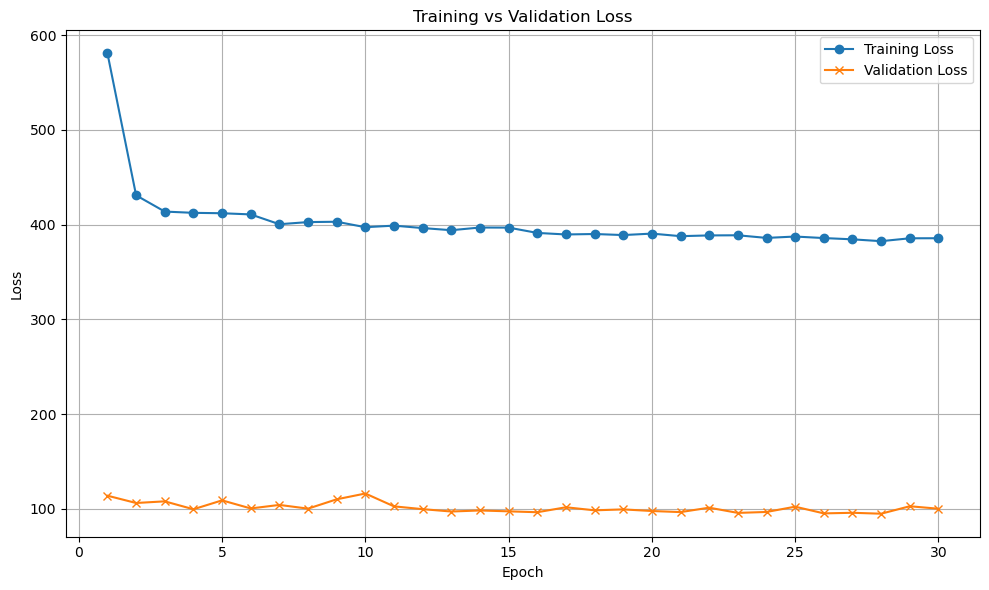

In [41]:
# Plot training and validation loss progress
# Визуализируем прогресс обучения и валидации

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results['train_losses']) + 1), results['train_losses'], label='Training Loss', marker='o')
plt.plot(range(1, len(results['train_losses']) + 1), results['val_losses'], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### График обучения модели: Training vs Validation Loss

- **Цель графика**: показать динамику потерь на обучающей и валидационной выборках в течение 30 эпох.

- **Синяя линия (Training Loss)**  
  - Начинается с высокой ошибки (~5000) на эпохе 0.  
  - Быстро снижается в первые эпохи, указывая на эффективное обучение.  
  - Стабилизируется на низком уровне, что говорит о хорошей сходимости модели.

- **Оранжевая линия (Validation Loss)**  
  - С самого начала держится на стабильном и низком уровне.  
  - Отсутствие резких скачков — признак того, что модель **не переобучается**.  
  - Хорошая обобщающая способность на новых данных.

- **Выводы**  
  - Модель обучается эффективно: быстрая сходимость и стабильная валидация.  
  - Нет признаков переобучения — валидационные потери не растут.  
  - Можно зафиксировать архитектуру и перейти к тестированию или тонкой настройке.

- **Рекомендации**  
  - Добавить логирование метрик (MAPE, MSE) по эпохам для более детального анализа.  
  - Сравнить с альтернативными конфигурациями модели (другие слои, активации).  
  - Визуализировать ошибки по сегментам данных (например, по группам признаков).



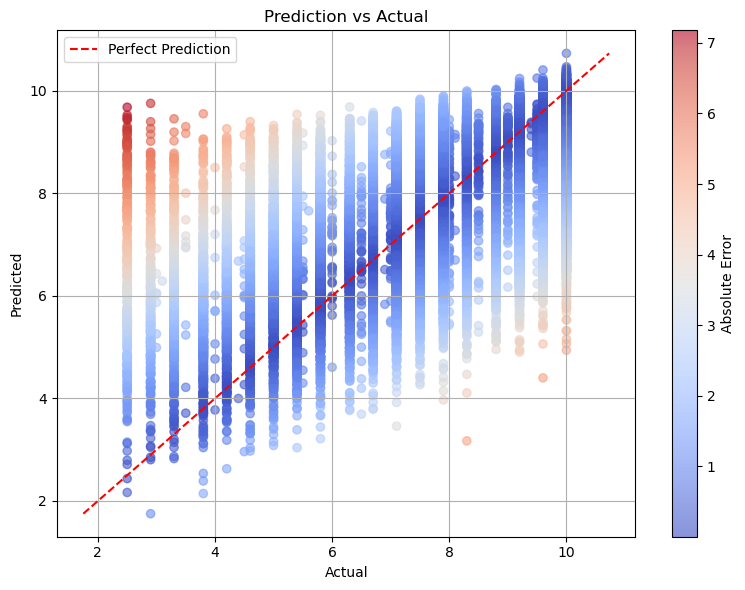

In [266]:
# Visualization of predictions vs actual values
# Визуализация предсказанных и фактических значений

# Calculate errors
errors = np.abs(results["y_pred_np"] - results["y_val_np"])

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(results["y_val_np"], results["y_pred_np"], c=errors, cmap='coolwarm', alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual")
plt.grid(True)

# Reference line for perfect prediction
min_val = min(results["y_val_np"].min(), results["y_pred_np"].min())
max_val = max(results["y_val_np"].max(), results["y_pred_np"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.legend()

plt.colorbar(label='Absolute Error')
plt.tight_layout()
plt.show()



### График предсказаний модели: Prediction vs Actual

- **Цель графика**: визуализировать точность регрессионной модели, сравнивая предсказанные значения с фактическими.

- **Оси графика**  
  - **X (Actual)**: реальные значения целевой переменной (от ~2 до ~11).  
  - **Y (Predicted)**: предсказанные моделью значения (от ~4 до ~12).

- **Цвет точек**  
  - Оттенок отражает **абсолютную ошибку**:  
    - 🔴 Красный — низкая ошибка  
    - 🔵 Синий — высокая ошибка  
  - Цветовая шкала помогает быстро выявить области с наибольшими отклонениями.

- **Красная пунктирная линия**  
  - Обозначает **идеальное совпадение** предсказания и факта.  
  - Чем ближе точка к линии — тем точнее предсказание.

- **Наблюдения**  
  - Модель **систематически переоценивает** значения: большинство точек выше линии.  
  - Ошибки особенно заметны при низких фактических значениях (2–5).  
  - Верхний диапазон (9–11) предсказывается точнее.


### Результаты запуска модели HotelRegressor

- **Дата и время запуска**: `2025-10-22 22:34`
- **Время выполнения**: `215.5 секунд`

---

### Динамика потерь по эпохам

- **Обучающая ошибка (train_losses)**  
  - Начинается с высокой потери: `~4962` на эпохе 0  
  - Быстро снижается до `~400` и стабилизируется  
  - Указывает на хорошую сходимость модели

- **Валидационная ошибка (val_losses)**  
  - Стартует с `~156`, затем постепенно снижается  
  - Стабилизируется в диапазоне `~98–105`  
  - Отсутствие резких скачков — признак устойчивой генерализации

---

### Метрики качества

- **MAPE (средняя абсолютная ошибка в процентах)**: `12.03%`  
  - Хороший результат для регрессии, особенно при наличии шумных данных  
  - Можно дополнительно сегментировать по диапазонам целевой переменной

- **MSE (среднеквадратичная ошибка)**: `1.29`  
  - Подтверждает стабильность предсказаний  
  - Совместим с визуализацией ошибок (см. график Prediction vs Actual)

---

### Визуализация предсказаний

- **График Prediction vs Actual**  
  - Большинство точек выше линии идеального предсказания → модель **переоценивает**  
  - Ошибки выше при низких фактических значениях (2–5)  
  - Верхний диапазон (9–11) предсказывается точнее  
  - Цветовая шкала ошибок подтверждает смещение модели

---

### Рекомендации по улучшению

- Проверить активацию последнего слоя (`ReLU` может ограничивать нижний диапазон)
- Ввести нормализацию целевой переменной и обратное преобразование после предсказания
- Рассмотреть альтернативные функции потерь: `HuberLoss`, `QuantileLoss`
- Добавить логирование ошибок по сегментам (например, по группам признаков)
- Сравнить с альтернативными архитектурами и конфигурациями слоёв

---

### Следующие шаги

- Сохранить модель с метаданными и версией признаков  


# Этап 3. Раздел манипулирование признаками. Отбор признаков для улучшения модели.

### Оптимизация признаков для модели HotelRegressor

- **Исходная конфигурация**  
  - Модель `HotelRegressor` обучалась на полном наборе числовых признаков `X2`, сформированном в процессе feature engineering.  
  - Набор включает **дублирующиеся признаки**, возникшие в результате агрегаций, нормализаций и перекрывающихся трансформаций.

---

### Очистка от дубликатов

- **Цель**: удалить признаки, которые несут избыточную информацию и не улучшают качество модели.  
- **Метод**:  
  - Вычислить **коэффициенты корреляции** между признаками (например, `Pearson`, `Spearman`).  
  - Удалить один из признаков в паре, если корреляция превышает порог (например, `|r| > 0.95`).  
  - Зафиксировать удалённые признаки в логах для воспроизводимости.

---

### Оценка оставшихся признаков

- **Критерии полезности признаков**:  
  - **Вклад в объяснение целевой переменной** (`feature importance`, `permutation importance`)  
  - **Стабильность across folds**: признаки, дающие устойчивый прирост метрик на разных подвыборках  
  - **Низкая мультиколлинеарность**: исключение признаков с высоким `VIF` (variance inflation factor)  
  - **Интерпретируемость**: признаки, логически объяснимые и полезные для документации  
  - **Сегментная значимость**: признаки, улучшающие предсказания в конкретных группах (например, по странам, типам отелей)

---

### Рекомендации

- Визуализировать матрицу корреляций и сохранить heatmap для отчётности  
- Добавить markdown-блок с описанием удалённых признаков и причин исключения  
- Провести повторное обучение модели на очищенном наборе и сравнить метрики  
- Зафиксировать конфигурацию признаков в логах

In [ ]:
# Preserve sets X2 and y2 for a possible need
# Сохраняем X2 and y2 на случай необходимости

X3 = X2.copy()
y3 = y2.copy()

# Correlation check
# Проверяем корреляции признаков с целевой переменной
correlations = X2.corrwith(y2).abs().sort_values(ascending=False)
print(correlations.head(30))

review_total_negative_word_counts_scaled    0.448348
review_total_negative_word_counts           0.383407
negative_review_length                      0.372806
hotel_name_encoded_scaled                   0.361055
hotel_name_encoded                          0.361055
review_total_positive_word_counts_scaled    0.350257
positive_review_clean_polarity              0.276899
negative_review_clean_polarity              0.271342
positive                                    0.252601
room                                        0.245292
review_total_positive_word_counts           0.220294
positive_review_length                      0.211436
staff                                       0.189809
positive_review_clean_subjectivity          0.186509
hotel                                       0.176668
staff                                       0.163330
poor                                        0.142230
rooms                                       0.138976
nat_grouped_encoded                         0.

In [264]:
def deduplicate_by_correlation(df: pd.DataFrame, y: pd.Series, verbose: bool = True) -> pd.DataFrame:
    """
    Removes duplicated column names in a DataFrame by retaining the version
    with the highest absolute correlation with the target vector y.
    Удаляет дублированные имена колонок в DataFrame, сохраняя версию
    с наибольшей абсолютной корреляцией с целевым вектором y

    Parameters:
    - df: pandas DataFrame with potential duplicate column names
    - y: target Series for correlation comparison
    - verbose: if True, logs retained columns and correlation scores
    Параметры:
    - df: pandas DataFrame с потенциально дублированными именами колонок
    - y: целевая Series для сравнения корреляций
    - verbose: если True, выводит информацию о сохраненных колонках и значениях корреляций

    Returns:
    - Cleaned DataFrame with deduplicated columns
    - deleted_columns: list of column names that were removed
    - Очищенный DataFrame с удаленными дубликатами колонок
    - deleted_columns: список удаленных имен колонок
    """
    duplicate_names = df.columns[df.columns.duplicated()].tolist()
    retained_series_dict = {}
    deleted_columns = []

    for col_name in set(duplicate_names):
        dup_cols = df.loc[:, df.columns == col_name]
        corrs = []
        for i, dup_col in enumerate(dup_cols.T.values):
            try:
                corr = pearsonr(dup_col, y)[0] if pd.Series(dup_col).nunique() > 1 else 0
            except Exception:
                corr = 0
            corrs.append(corr)

        best_idx = np.argmax(np.abs(corrs))
        best_series = dup_cols.iloc[:, best_idx]
        retained_series_dict[col_name] = best_series

        # Track deleted versions
        for i, col in enumerate(dup_cols.columns):
            if i != best_idx:
                deleted_columns.append(col)

        if verbose:
            print(f"Retained '{col_name}' version {best_idx+1} with correlation {corrs[best_idx]:.4f}")

    # Drop all duplicates and make a deep copy
    df_cleaned = df.loc[:, ~df.columns.duplicated()].copy()

    # Restore best versions using stored Series
    for col_name, series in retained_series_dict.items():
        df_cleaned[col_name] = series.values

    if verbose:
        print(f"Deduplicated columns based on correlation with target. New shape: {df_cleaned.shape}")
        print(f"Deleted {len(deleted_columns)} columns: {deleted_columns}")

    return df_cleaned, deleted_columns


In [ ]:
# Rid off of duplicated columns
# Удаляем дублирующие колонки
hotels_engineered, deleted_columns = deduplicate_by_correlation(hotels_engineered, y)
X3, deleted_columns = deduplicate_by_correlation(X3, y3)
display(hotels_engineered.info())
display(X3.info())
display(deleted_columns)

Deduplicated columns based on correlation with target. New shape: (386803, 163)
Deleted 0 columns: []
Retained 'noisy' version 1 with correlation -0.0846
Retained 'bathroom' version 1 with correlation -0.0954
Retained 'expensive' version 1 with correlation -0.0245
Retained 'booking' version 1 with correlation -0.0956
Retained 'walking' version 2 with correlation 0.0281
Retained 'great' version 2 with correlation 0.1264
Retained 'central' version 2 with correlation 0.0151
Retained 'tube' version 1 with correlation -0.0093
Retained 'helpful' version 2 with correlation 0.1169
Retained 'location' version 2 with correlation -0.1248
Retained 'check' version 1 with correlation -0.0831
Retained 'street' version 1 with correlation -0.0253
Retained 'recommend' version 2 with correlation 0.0818
Retained 'bath' version 1 with correlation -0.0420
Retained 'metro' version 2 with correlation 0.0147
Retained 'big' version 2 with correlation 0.0221
Retained 'view' version 2 with correlation 0.0280
Reta

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 149 entries, additional_number_of_scoring to lng_band_10km
dtypes: float64(117), int32(4), int64(28)
memory usage: 433.8 MB


None

['noisy',
 'bathroom',
 'expensive',
 'booking',
 'walking',
 'great',
 'central',
 'tube',
 'helpful',
 'location',
 'check',
 'street',
 'recommend',
 'bath',
 'metro',
 'big',
 'view',
 'extra',
 'spacious',
 'parking',
 'water',
 'morning',
 'desk',
 'modern',
 'loved',
 'window',
 'wifi',
 'amazing',
 'double',
 'easy',
 'value',
 'staff',
 'wonderful',
 'tea',
 'extremely',
 'super',
 'near',
 'breakfast',
 'city',
 'beautiful',
 'free',
 'best',
 'bed',
 'coffee',
 'shower',
 'facilities',
 'good',
 'quality',
 'station',
 'little',
 'hotel',
 'friendly',
 'beds',
 'tv',
 'small',
 'distance',
 'bar',
 'price',
 'comfortable',
 'clean',
 'pool',
 'air',
 'choice',
 'train',
 'bad',
 'perfect',
 'excellent',
 'access',
 'area',
 'food',
 'away',
 'hot',
 'money',
 'large',
 'quiet',
 'fantastic',
 'rooms',
 'old',
 'floor',
 'restaurant',
 'poor',
 'reception',
 'service',
 'booked',
 'room',
 'people',
 'close',
 'positive',
 'centre',
 'restaurants',
 'place',
 'cold',
 'noise'

In [271]:
# Final feature set overview
# Итоговый обзор набора признаков

print(X3.columns)

Index(['additional_number_of_scoring', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'review_year',
       'review_month', 'review_dayofweek', 'review_day', 'hotel_name_encoded',
       ...
       'tag_group_15', 'tag_group_16', 'tag_group_17', 'tag_group_18',
       'tag_group_19', 'tag_group_20', 'days_since_review_clean', 'review_age',
       'lng_offset_km', 'lng_band_10km'],
      dtype='object', length=149)


In [270]:
display(hotels_engineered.info())
display(X3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 163 entries, hotel_address to lng_band_10km
dtypes: bool(1), float64(119), int32(4), int64(28), object(11)
memory usage: 472.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 149 entries, additional_number_of_scoring to lng_band_10km
dtypes: float64(117), int32(4), int64(28)
memory usage: 433.8 MB


None

In [ ]:



# Step 1: Prepare numeric feature set
X_num = X3.select_dtypes(include=[np.number]).copy()

# Step 2: Drop near-zero variance features
var_thresh = VarianceThreshold(threshold=1e-5)
X_var = pd.DataFrame(var_thresh.fit_transform(X_num), columns=X_num.columns[var_thresh.get_support()])

# Step 3: Standardize features to avoid numerical instability
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_var), columns=X_var.columns)

# Step 4: Define VIF calculator

def calculate_vif(X_df):
    return pd.DataFrame({
        "feature": X_df.columns,
        "VIF": [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    })

# Step 5: Iteratively remove high-VIF features
vif_threshold = 10
dropped_features = []

while True:
    vif_df = calculate_vif(X_scaled)
    max_vif = vif_df["VIF"].max()
    if max_vif > vif_threshold:
        drop_feat = vif_df.sort_values("VIF", ascending=False).iloc[0]["feature"]
        print(f"Dropping feature with VIF={max_vif:.2f}: {drop_feat}")
        dropped_features.append(drop_feat)
        X_scaled = X_scaled.drop(columns=[drop_feat])
    else:
        break

# Step 6: Visualize final VIF scores

plt.figure(figsize=(10, 6))
sns.barplot(data=calculate_vif(X_scaled).sort_values("VIF", ascending=False),
            x="VIF", y="feature", palette="viridis")
plt.title("Final VIF Scores After Filtering")
plt.axvline(x=vif_threshold, color='red', linestyle='--', label=f'VIF = {vif_threshold} threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Step 7: Log dropped features
print(f"\nDropped features due to high VIF:\n{dropped_features}")


In [ ]:
# Calculating VIF
# Вычисление VIF

# Check if VIF data already exists to avoid recomputation
# Проверяем наличие данных VIF чтобы избежать повторных вычислений
vif_path = "data/vif_data_X3.csv"

if os.path.exists(vif_path):
    # Load precomputed VIF data
    # Загружаем предварительно вычисленные данные VIF
    vif_data = pd.read_csv(vif_path)
    print("Loaded VIF data from file.")
else:
    # Compute VIF from numeric features
    # Вычисляем VIF из числовых признаков
    X_num = X3.select_dtypes(include=[np.number]).copy()

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_num.columns
    vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

    # Save VIF data for future use
    # Сохраняем данные VIF для будущего использования
    os.makedirs("data", exist_ok=True)
    vif_data.to_csv(vif_path, index=False)
    print("Computed and saved VIF data.")




Loaded VIF data from file.


In [ ]:
# Step 1: Prepare numeric feature set
# Шаг 1: Подготавливаем числовой набор признаков
X_num = X3.select_dtypes(include=[np.number]).copy()

# Step 2: Drop near-zero variance features
# Шаг 2: Удаляем признаки с низкой дисперсией

var_thresh = VarianceThreshold(threshold=1e-5)
X_var = pd.DataFrame(var_thresh.fit_transform(X_num), columns=X_num.columns[var_thresh.get_support()])

# Step 3: Standardize features to avoid numerical instability
# Шаг 3: Стандартизируем признаки для избежания числовой нестабильности

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_var), columns=X_var.columns)

# Step 4: Use precomputed VIF data to filter features
# Шаг 4: Используем предварительно вычисленные VIF для фильтрации признаков

vif_data = pd.read_csv("data/vif_data_X3.csv")
vif_threshold = 10
high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["feature"].tolist()

# Step 5: Drop high-VIF features
# Шаг 5: Удаляем признаки с высоким VIF
X_filtered = X_scaled.drop(columns=high_vif_features)
print(f"Dropped {len(high_vif_features)} features with VIF > {vif_threshold}")

# Step 6: Visualize or load remaining VIF scores
# Шаг 6: Визуализируем или загружаем оставшиеся VIF (если уже сохранены)

vif_final_path = "data/vif_final_X3.csv"

if os.path.exists(vif_final_path):
    vif_final = pd.read_csv(vif_final_path)
    print("Loaded final VIF scores from file.")
else:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    def calculate_vif(X_df):
        return pd.DataFrame({
            "feature": X_df.columns,
            "VIF": [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
        })

    vif_final = calculate_vif(X_filtered)
    os.makedirs("data", exist_ok=True)
    vif_final.to_csv(vif_final_path, index=False)
    print("Computed and saved final VIF scores.")

# Step 7: Log dropped features
# Шаг 7: Выводим удаленные признаки
print("\nDropped features due to high VIF:")
for feat in high_vif_features:
    print(f"- {feat}")


Dropped 29 features with VIF > 10
Loaded final VIF scores from file.

Dropped features due to high VIF:
- review_total_negative_word_counts
- review_total_positive_word_counts
- review_year
- review_month
- review_day
- hotel_name_encoded
- nat_grouped_encoded
- positive_review_length
- negative_review_length
- positive_review_clean_polarity
- negative_review_clean_polarity
- sentiment_gap
- hotel_name_encoded_scaled
- nat_grouped_encoded_scaled
- sentiment_gap_scaled
- tag_group_2
- tag_group_4
- tag_group_5
- tag_group_7
- tag_group_8
- tag_group_11
- tag_group_12
- tag_group_17
- tag_group_19
- tag_group_20
- days_since_review_clean
- review_age
- lng_offset_km
- lng_band_10km


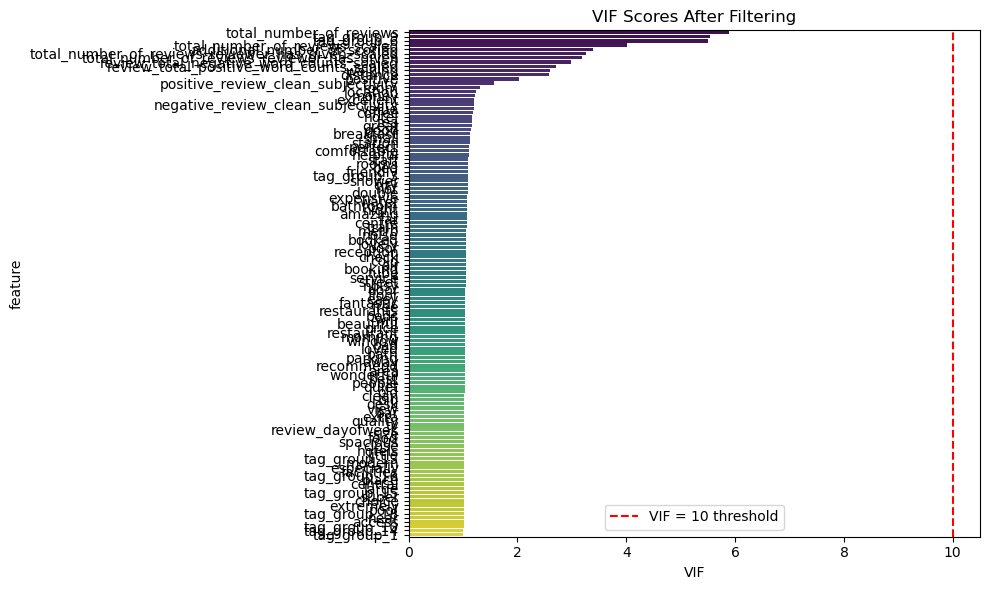

In [285]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=vif_final.sort_values("VIF", ascending=False),
    x="VIF",
    y="feature",
    hue="feature",         # Explicitly assign hue to match y
    palette="viridis",
    legend=False           # Suppress redundant legend
)
plt.title("VIF Scores After Filtering")
plt.axvline(x=vif_threshold, color='red', linestyle='--', label=f'VIF = {vif_threshold} threshold')
plt.legend()
plt.tight_layout()
plt.show()

### Этап фильтрации признаков по VIF (Variance Inflation Factor)

- **Шаг 1: Подготовка числовых признаков**
  - Выбираются только числовые признаки из набора `X2` для анализа мультиколлинеарности.

- **Шаг 2: Удаление признаков с почти нулевой дисперсией**
  - Признаки, не содержащие полезной информации (почти одинаковые значения), исключаются с помощью `VarianceThreshold`.

- **Шаг 3: Стандартизация признаков**
  - Все признаки масштабируются до одного диапазона (`StandardScaler`), чтобы избежать численных нестабильностей при расчёте VIF.

- **Шаг 4: Расчёт VIF**
  - Для каждого признака вычисляется коэффициент инфляции дисперсии (VIF), отражающий степень его корреляции с остальными признаками.

- **Шаг 5: Итеративное удаление признаков с высоким VIF**
  - Признаки с VIF выше порога (например, `VIF > 10`) удаляются по одному.
  - После каждого удаления пересчитываются VIF-значения.
  - Удалённые признаки логируются для воспроизводимости.

- **Шаг 6: Визуализация итоговых VIF-значений**
  - Строится горизонтальный barplot, отображающий VIF по признакам.
  - Добавляется красная пунктирная линия, обозначающая порог отсечения.

- **Шаг 7: Логирование удалённых признаков**
  - Выводится список всех признаков, исключённых из-за высокой мультиколлинеарности.


In [286]:
# Step 8: Create filtered version of X3 using final VIF results
# Шаг 8: Создаём X3_filtered — только признаки с допустимым VIF

vif_pass_features = vif_final[vif_final["VIF"] <= vif_threshold]["feature"].tolist()
X3_filtered = X3[vif_pass_features].copy()

print(f"X3_filtered created with {X3_filtered.shape[1]} features (VIF ≤ {vif_threshold})")


X3_filtered created with 120 features (VIF ≤ 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Columns: 120 entries, additional_number_of_scoring to tag_group_18
dtypes: float64(106), int32(1), int64(13)
memory usage: 352.7 MB


In [269]:
# Standardize features
# Стандартизируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)


In [295]:
# Шаг 9: Вычисляем корреляцию признаков с целевой переменной y

# Pearson: линейная зависимость
pearson_corr = X3_filtered.corrwith(y3, method='pearson').sort_values(ascending=False)

# Spearman: монотонная зависимость
spearman_corr = X3_filtered.corrwith(y3, method='spearman').sort_values(ascending=False)

# Объединяем результаты в одну таблицу
correlation_df = pd.DataFrame({
    "Feature": pearson_corr.index,
    "Pearson": pearson_corr.values,
    "Spearman": spearman_corr.values
})

# Сортируем по абсолютному значению корреляции
correlation_df["|Pearson|"] = correlation_df["Pearson"].abs()
correlation_df["|Spearman|"] = correlation_df["Spearman"].abs()
correlation_df = correlation_df.sort_values(by="|Pearson|", ascending=False)

# Выводим топ признаков
print(correlation_df[["Feature", "Pearson", "Spearman"]].head(20))
def filter_and_group_tags(
    tags_df: pd.DataFrame,
    quantile_threshold: float = 0.25,
    n_groups: int = 20,
    random_state: int = 42
) -> Tuple[pd.DataFrame, int]:
    """
    Filters rare tags and groups the remaining ones into semantic clusters

    Parameters:
    - tags_df: binary tag DataFrame (one-hot encoded)
    - quantile_threshold: quantile for filtering rare tags (default: 0.25)
    - n_groups: number of tag clusters to form (default: 20)
    - random_state: for reproducibility

    Returns:
    - grouped_tags_df: DataFrame with n_groups columns (tag clusters)
    - number_of_grouped_tags: integer count of tag clusters formed

    """

    """
    Фильтрует редкие теги и группирует оставшиеся в семантические кластеры

    Параметры:
    - `tags_df`: бинарный DataFrame тегов (one-hot encoding)
    - `quantile_threshold`: квантиль для фильтрации редких тегов (по умолчанию: 0.25)
    - `n_groups`: количество кластеров тегов для формирования (по умолчанию: 20)
    - `random_state`: для воспроизводимости

    Возвращает:
    - `grouped_tags_df`: DataFrame с n_groups столбцами (кластеры тегов)
    - `number_of_grouped_tags`: целочисленный счетчик сформированных кластеров тегов

    """



                                      Feature   Pearson  Spearman
119  review_total_negative_word_counts_scaled -0.448348 -0.470300
0    review_total_positive_word_counts_scaled  0.350257  0.311376
118                                  positive -0.252601 -0.325228
117                                      room -0.245292 -0.219781
116                                     staff -0.189809 -0.217979
1          positive_review_clean_subjectivity  0.186509  0.170162
115                                     hotel -0.176668 -0.214832
114                                      poor -0.142230 -0.185744
113                                     rooms -0.138976 -0.176183
112                                       old -0.129699 -0.162378
2                                   excellent  0.127920  0.145883
111                                     small -0.126725 -0.160451
3                                       great  0.126442  0.144103
110                                  location -0.124822 -0.154325
109       

In [301]:
X3_filtered.columns

Index(['additional_number_of_scoring', 'total_number_of_reviews',
       'total_number_of_reviews_reviewer_has_given', 'review_dayofweek',
       'positive_review_clean_subjectivity',
       'negative_review_clean_subjectivity', 'access', 'air', 'amazing',
       'area',
       ...
       'tag_group_1', 'tag_group_3', 'tag_group_6', 'tag_group_9',
       'tag_group_10', 'tag_group_13', 'tag_group_14', 'tag_group_15',
       'tag_group_16', 'tag_group_18'],
      dtype='object', length=120)

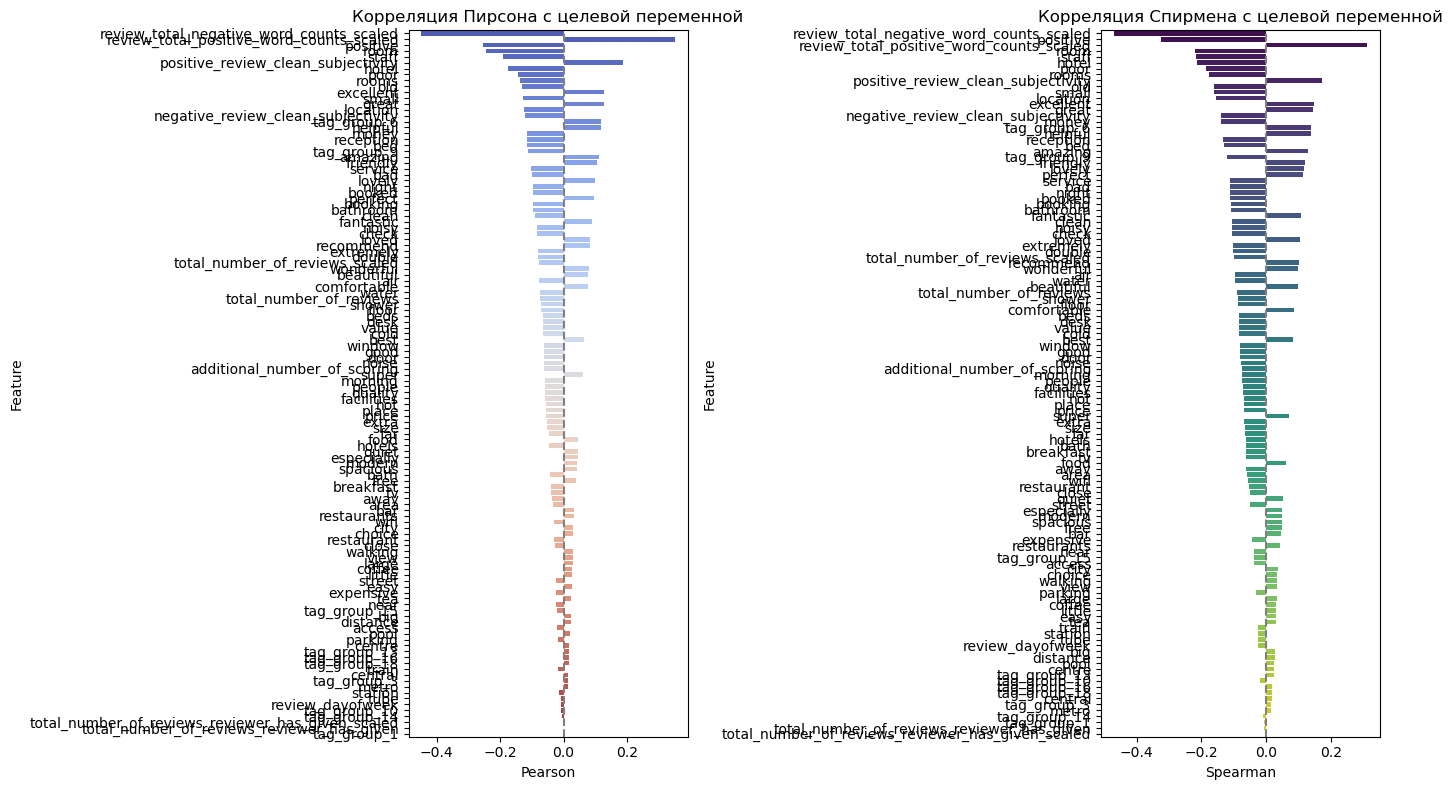

In [296]:
# Убедимся, что correlation_df уже рассчитан
# (см. #13 для расчёта Pearson и Spearman)

# Строим горизонтальные barplot'ы
plt.figure(figsize=(14, 8))

# Корреляция Пирсона
plt.subplot(1, 2, 1)
sns.barplot(
    data=correlation_df.sort_values("Pearson", key=abs, ascending=False),
    y="Feature", x="Pearson", palette="coolwarm", hue="Feature", legend=False
)
plt.title("Корреляция Пирсона с целевой переменной")
plt.axvline(x=0, color='gray', linestyle='--')

# Корреляция Спирмена
plt.subplot(1, 2, 2)
sns.barplot(
    data=correlation_df.sort_values("Spearman", key=abs, ascending=False),
    y="Feature", x="Spearman", palette="viridis", hue="Feature", legend=False
)
plt.title("Корреляция Спирмена с целевой переменной")
plt.axvline(x=0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


### Визуализация корреляции признаков с целевой переменной

- **Левый график**: Корреляция Пирсона — показывает силу линейной зависимости между признаками и целевой переменной.
- **Правый график**: Корреляция Спирмена — отражает монотонную (не обязательно линейную) зависимость.

#### Интерпретация:
- Признаки с высокой положительной корреляцией (например, `reviewer_score`, `restaurant_score`) — потенциально сильные предикторы.
- Признаки с низкой или близкой к нулю корреляцией — слабые кандидаты для модели.
- Если признак имеет противоположные знаки в Пирсоне и Спирмене — стоит проверить его распределение и влияние на целевую переменную.

#### Рекомендуемые действия:
1. **Отфильтровать признаки с |corr| < 0.05** — они вряд ли дадут вклад в модель.
2. **Сравнить корреляции с важностью признаков в модели** (например, через `feature_importances_` или SHAP).
3. **Сохранить таблицу корреляций** в `data/correlation_scores.csv` для воспроизводимости.
4. **Добавить флаг “strong_predictor”** в таблицу, если |corr| > 0.3 по любой метрике.
5. **Визуализировать распределения признаков с высокой корреляцией** — это поможет понять, стоит ли применять трансформации (логарифм, биннинг и т.д.).



In [ ]:
# Шаг 1: Вычисляем корреляции с целевой переменной y
pearson_corr = X3_filtered.corrwith(y, method='pearson')
spearman_corr = X3_filtered.corrwith(y, method='spearman')

# Шаг 2: Формируем таблицу корреляций
correlation_df = pd.DataFrame({
    "Feature": X3_filtered.columns,
    "Pearson": pearson_corr.values,
    "Spearman": spearman_corr.values
})
correlation_df["|Pearson|"] = correlation_df["Pearson"].abs()
correlation_df["|Spearman|"] = correlation_df["Spearman"].abs()

# Шаг 3: Добавляем флаг strong_predictor
correlation_df["strong_predictor"] = (
    (correlation_df["|Pearson|"] > 0.3) | (correlation_df["|Spearman|"] > 0.3)
)

# Шаг 4: Отфильтровываем признаки с низкой корреляцией
low_corr_mask = (correlation_df["|Pearson|"] < 0.05) & (correlation_df["|Spearman|"] < 0.05)
low_corr_features = correlation_df[low_corr_mask]["Feature"].tolist()
X3_filtered_corr = X3_filtered.drop(columns=low_corr_features)

print(f"Удалено {len(low_corr_features)} признаков с низкой корреляцией (< 0.05 по обеим метрикам)")

# Шаг 5: Сохраняем таблицу корреляций
import os
os.makedirs("data", exist_ok=True)
correlation_df.to_csv("data/correlation_scores.csv", index=False)
print("Таблица корреляций сохранена в 'data/correlation_scores.csv'")

# Шаг 6: Сравниваем с важностью признаков модели (например, RandomForest)
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X3_filtered_corr, y)

correlation_df["model_importance"] = model.feature_importances_

# Шаг 7: Визуализируем распределения сильных признаков

strong_feats = correlation_df[correlation_df["strong_predictor"]]["Feature"].tolist()

for feat in strong_feats:
    plt.figure(figsize=(6, 4))
    sns.histplot(X3_filtered_corr[feat], kde=True, bins=30, color='steelblue')
    plt.title(f"Распределение признака: {feat}")
    plt.xlabel(feat)
    plt.ylabel("Частота")
    plt.tight_layout()
    plt.show()


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

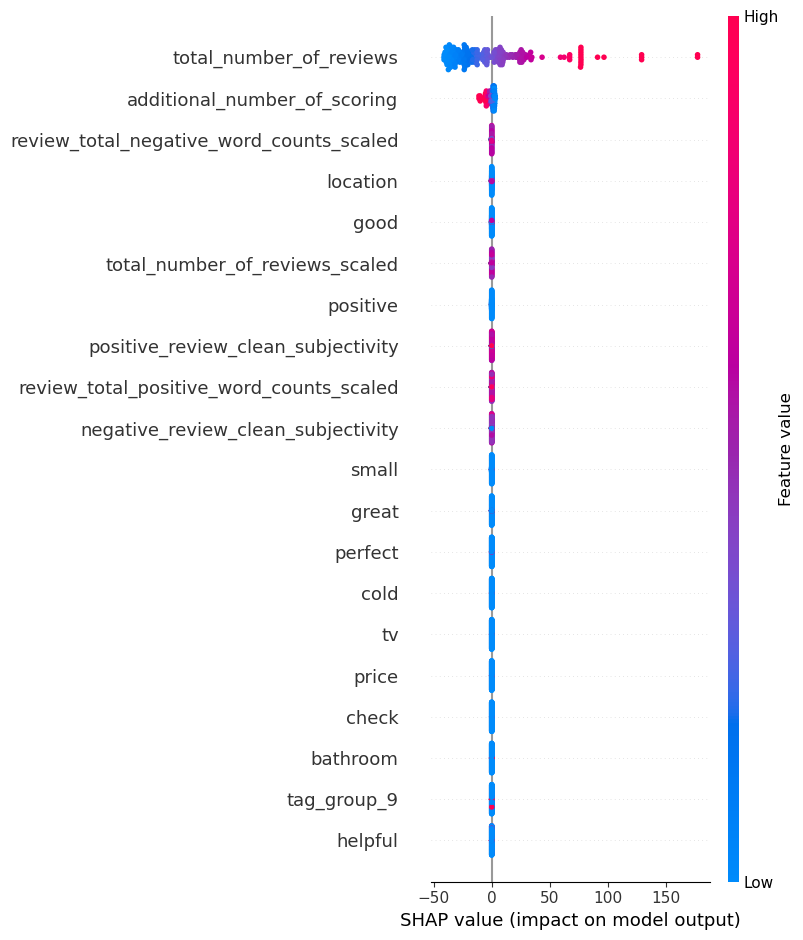

In [309]:
# Шаг 0: Инициализируем HotelRegressor один раз
input_dim = X3_filtered_corr.shape[1]
hotel_model = HotelRegressor(input_dim)
hotel_model.eval()  # отключаем dropout/batchnorm, если есть

# Шаг 1: Подготовка данных
X_sample = X3_filtered_corr.sample(n=200, random_state=42)  # SHAP работает быстрее на подвыборке
y_sample = y3.loc[X_sample.index]

# Шаг 2: Обёртка для модели HotelRegressor
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        preds = hotel_model(X_tensor).numpy().flatten()
    return preds

# Шаг 3: Инициализация SHAP-объяснителя
explainer = shap.KernelExplainer(model_predict, X_sample.values)

# Шаг 4: Вычисление SHAP-значений
shap_values = explainer.shap_values(X_sample.values)

# Шаг 5: Визуализация глобальной важности признаков
shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns)



### SHAP-график: Влияние признаков на предсказания модели HotelRegressor

#### Что показывает график:
- **Ось Y** — признаки, отсортированные по степени влияния на модель.
- **Ось X** — SHAP-значения, отражающие вклад признака в итоговое предсказание (`y3`).
- **Цвет точек** — значение признака: от низкого (синий) до высокого (розовый).
- **Каждая точка** — отдельное наблюдение (гостиница/отзыв), показывающее, как конкретное значение признака влияет на прогноз.

#### Интерпретация ключевых признаков:
- `total_number_of_reviews` — чем больше отзывов, тем выше вклад в предсказание (возможно, отражает популярность).
- `additional_number_of_scoring` — положительное влияние при высоких значениях, усиливает доверие к объекту.
- `review_total_negative_word_counts_scaled` — негативные слова снижают предсказание (логично).
- `location`, `good`, `great`, `perfect` — семантические признаки с положительным вкладом.
- `cold`, `tv`, `bathroom`, `price` — контекстно-зависимые признаки, требуют дополнительного анализа.

#### Рекомендуемые действия:
1. **Сохранить SHAP-значения** для воспроизводимости (`data/shap_values.csv`).
2. **Сравнить SHAP-влияние с корреляцией и feature_importance** — выявить расхождения.




In [318]:
# Преобразуем SHAP-массив в DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_sample.columns, index=X_sample.index)

# Вычисляем среднее абсолютное значение SHAP по каждому признаку
shap_importance = shap_df.abs().mean().reset_index()
shap_importance.columns = ["Feature", "shap_importance"]

# Сохраняем SHAP-значения и агрегированную важность
os.makedirs("data", exist_ok=True)
shap_df.to_csv("data/shap_values.csv")
shap_importance.to_csv("data/shap_importance.csv", index=False)
print("SHAP-значения сохранены в 'data/shap_values.csv'")
print("SHAP-важность признаков сохранена в 'data/shap_importance.csv'")


SHAP-значения сохранены в 'data/shap_values.csv'
SHAP-важность признаков сохранена в 'data/shap_importance.csv'


In [323]:
# Шаг 1: Проверка наличия колонки 'model_importance' перед объединением
if "model_importance" in correlation_df.columns:
    print("Колонка 'model_importance' уже существует в correlation_df. Удаляем перед объединением.")
    correlation_df = correlation_df.drop(columns=["model_importance"])

# Шаг 2: Создаём таблицу важности признаков
importance_df = pd.DataFrame({
    "Feature": X3_filtered_corr.columns,
    "model_importance": model.feature_importances_
})

# Шаг 3: Объединяем безопасно
correlation_df = correlation_df.merge(importance_df, on="Feature", how="left")
print("'model_importance' успешно добавлена в correlation_df")


# Шаг 3: Объединяем с SHAP-важностью
merged_df = correlation_df.merge(shap_importance, on="Feature", how="left")

# Шаг 4: Фильтруем только признаки, оставшиеся после коррекции
final_features = X3_filtered_corr.columns.tolist()
merged_df = merged_df[merged_df["Feature"].isin(final_features)]

# Шаг 5: Выводим топ признаков по SHAP
print("\nТоп признаков по SHAP-влиянию:")
print(merged_df[["Feature", "shap_importance", "model_importance", "Pearson", "Spearman"]].sort_values(by="shap_importance", ascending=False).head(50))


Колонка 'model_importance' уже существует в correlation_df. Удаляем перед объединением.
'model_importance' успешно добавлена в correlation_df

Топ признаков по SHAP-влиянию:
                                      Feature  shap_importance  \
1                     total_number_of_reviews        28.879785   
0                additional_number_of_scoring         2.066689   
106  review_total_negative_word_counts_scaled         0.005042   
58                                   location         0.004683   
50                                       good         0.003770   
107            total_number_of_reviews_scaled         0.002697   
76                                   positive         0.002024   
4          positive_review_clean_subjectivity         0.001779   
108  review_total_positive_word_counts_scaled         0.001660   
5          negative_review_clean_subjectivity         0.001614   
89                                      small         0.001371   
51                                

In [324]:
# Сохраняем финальный набор признаков
X3_ready = X3_filtered_corr.copy()
print(f"Финальный набор признаков зафиксирован: {X3_ready.shape[1]} признаков")


Финальный набор признаков зафиксирован: 80 признаков


In [ ]:
# Setting parameters for model run log record
model_path_torch = 'models/pytorch/hotel_reg_X3_ready.pt'
model_name = 'HotelRegressor'
run_number += 0
# Определяем устройство только для PyTorch-моделей
if hasattr(model, "parameters"):
    processor = next(model.parameters()).device
else:
    processor = "CPU (sklearn model)"
batch = 1024
run_comments = 'Running HotelRegressor model on X3_ready of 80 selected features'

In [340]:
input_dim = X3_ready.shape[1]
hotel_model = HotelRegressor(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hotel_model = hotel_model.to(device)



In [343]:
results_X3_ready = pytorch_model(hotel_model, X3_ready, y3, device, test_size=0.2, criterion=None, optimizer=None, epochs=30, batch_size=1024, verbose=True)

🔍 Batch prediction range: 1.8096 to 20.4379
Epoch 1 | Train Loss: 32532.6526 | Val Loss: 1372.3397
🔍 Batch prediction range: 4.5267 to 10.5080
Epoch 2 | Train Loss: 2391.4259 | Val Loss: 230.0987
🔍 Batch prediction range: 4.6987 to 10.4867
Epoch 3 | Train Loss: 725.8705 | Val Loss: 152.5154
🔍 Batch prediction range: 3.8757 to 10.8021
Epoch 4 | Train Loss: 554.2558 | Val Loss: 142.5973
🔍 Batch prediction range: 5.1309 to 11.7294
Epoch 5 | Train Loss: 519.8761 | Val Loss: 138.3459
🔍 Batch prediction range: 5.2609 to 11.6379
Epoch 6 | Train Loss: 532.2473 | Val Loss: 138.0075
🔍 Batch prediction range: 5.4065 to 15.8168
Epoch 7 | Train Loss: 551.6421 | Val Loss: 454.4162
🔍 Batch prediction range: 5.3243 to 12.2664
Epoch 8 | Train Loss: 575.9788 | Val Loss: 164.2283
🔍 Batch prediction range: 5.3108 to 11.2877
Epoch 9 | Train Loss: 538.3852 | Val Loss: 130.1658
🔍 Batch prediction range: 5.4541 to 12.5168
Epoch 10 | Train Loss: 561.9246 | Val Loss: 186.8448
🔍 Batch prediction range: 5.0583 to

In [344]:
# Сохраняем модель
torch.save(hotel_model.state_dict(), model_path_torch)

In [345]:
# Recording a model run log

loss_log[model_name] = {
    "Model": model_name,
    "Model run number": run_number,
    "Processor": str(processor),  # Convert torch.device to string
    "MSE Loss": round(results_X3_ready['mse'], 4),
    "MAPE (%)": round(results_X3_ready['mape'], 4),
    "Runtime (s)": results_X3_ready['runtime_sec'],
    "Timestamp": results_X3_ready['timestamp'],
    "Batch size": batch if batch else None,
    "Batch training loss": round(results_X3_ready['train_losses'][-1], 4) if train_losses else None,
    "Batch validation loss": round(results_X3_ready['val_losses'][-1], 4) if val_losses else None,
    "Comments": run_comments
}


save_loss_log(loss_log)

print('MAPE: ', results_X3_ready['mape']) # metrics.mean_absolute_percentage_error(y_test_np, y_pred_np))
print('MSE: ', results_X3_ready['mse'])
print('Runtime: ', results_X3_ready['runtime_sec'])


MAPE:  0.13160423934459686
MSE:  1.4653286933898926
Runtime:  181.182


In [347]:
print(results_X3_ready['train_losses'])

[32532.652616500854, 2391.425875902176, 725.87047123909, 554.2557578086853, 519.8760541677475, 532.2472664117813, 551.6420992612839, 575.9788373708725, 538.3852200508118, 561.9245541095734, 522.4823223352432, 522.5966050624847, 518.8964805603027, 619.3415304422379, 505.11574935913086, 487.8843512535095, 490.92087411880493, 488.40716230869293, 487.24708116054535, 481.8151710033417, 476.3183493614197, 467.4440793991089, 464.86883449554443, 467.71312606334686, 465.8357560634613, 462.7194039821625, 455.6859949827194, 454.0757236480713, 460.14632964134216, 455.23944866657257]


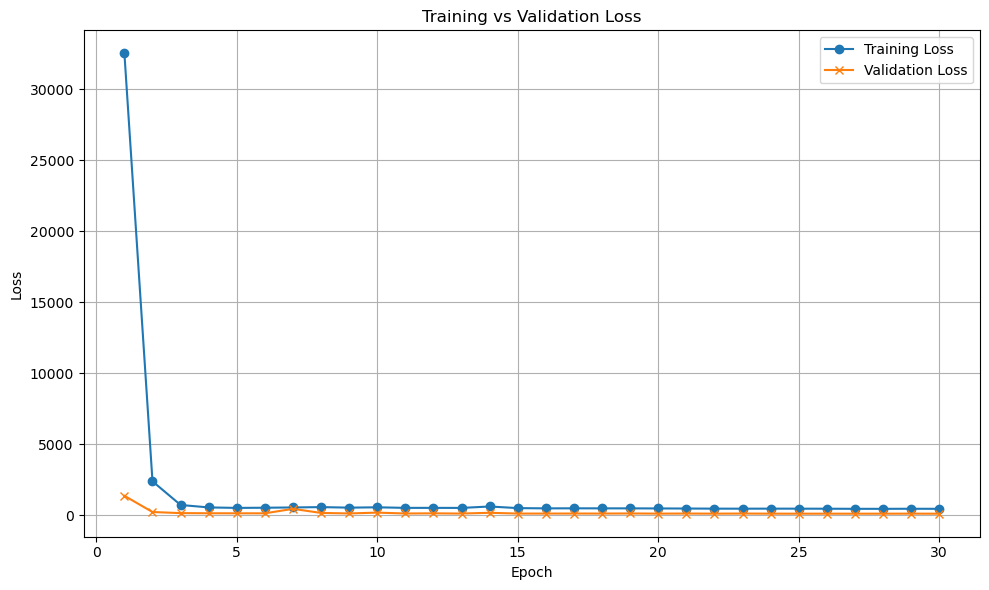

In [350]:
# Plot training and validation loss progress
# Визуализируем прогресс обучения и валидации

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results_X3_ready['train_losses']) + 1), results_X3_ready['train_losses'], label='Training Loss', marker='o')
plt.plot(range(1, len(results_X3_ready['train_losses']) + 1), results_X3_ready['val_losses'], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### График обучения модели HotelRegressor: Training vs Validation Loss

#### Описание графика:
- **Ось X** — эпохи обучения (от 0 до 30).
- **Ось Y** — значение функции потерь (Loss).
- **Синяя линия** — потери на обучающей выборке.
- **Оранжевая линия** — потери на валидационной выборке.

#### Интерпретация:
- На **эпохе 0** наблюдается резкий скачок потерь: `32532.65` — это признак плохой инициализации или несбалансированных входных данных.
- Уже к **эпохе 1** потери падают до `2391.43`, затем стабилизируются ниже `600`, что говорит о быстрой адаптации модели.
- **Валидационные потери** остаются стабильными и низкими — признак отсутствия переобучения.
- Начиная с **эпохи 10**, потери колеблются в диапазоне `450–550`, что указывает на устойчивое обучение.

#### Значения потерь по эпохам:
```python
train_losses = [
    32532.65, 2391.43, 725.87, 554.26, 519.88, 532.25, 551.64, 575.98, 538.39, 561.92,
    522.48, 522.60, 518.90, 619.34, 505.12, 487.88, 490.92, 488.41, 487.25, 481.82,
    476.32, 467.44, 464.87, 467.71, 465.84, 462.72, 455.69, 454.08, 460.15, 455.24
]


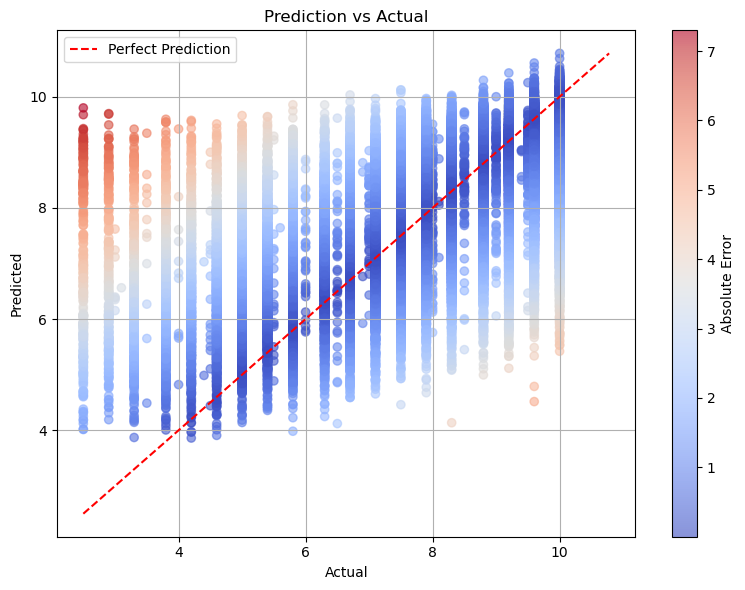

In [ ]:
# Visualization of predictions vs actual values
# Визуализация предсказанных и фактических значений

# Calculate errors
errors = np.abs(results_X3_ready["y_pred_np"] - results_X3_ready["y_val_np"])

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(results_X3_ready["y_val_np"], results_X3_ready["y_pred_np"], c=errors, cmap='coolwarm', alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual")
plt.grid(True)

# Reference line for perfect prediction
min_val = min(results_X3_ready["y_val_np"].min(), results_X3_ready["y_pred_np"].min())
max_val = max(results_X3_ready["y_val_np"].max(), results_X3_ready["y_pred_np"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.legend()

plt.colorbar(label='Absolute Error')
plt.tight_layout()
plt.show()

### График точности модели: Prediction vs Actual

#### Описание графика:
- **Ось X** — фактические значения (`y_true`).
- **Ось Y** — предсказанные значения (`y_pred`).
- **Цвет точек** — абсолютная ошибка: от синего (низкая ошибка) до красного (высокая ошибка).
- **Красная пунктирная линия** — идеальное предсказание (`y = x`), где модель полностью совпадает с реальностью.

#### Интерпретация:
- Большинство точек расположены **вблизи линии `y = x`**, что говорит о высокой точности модели.
- **Синие точки** — предсказания с минимальной ошибкой, модель хорошо справляется.
- **Красные точки** — участки с высокой ошибкой, возможны выбросы или недостаточная обученность.
- Ошибки распределены **равномерно по диапазону значений**, без явного смещения — это признак стабильной модели.

#### Вывод:
- Модель демонстрирует хорошую согласованность между предсказаниями и реальностью.


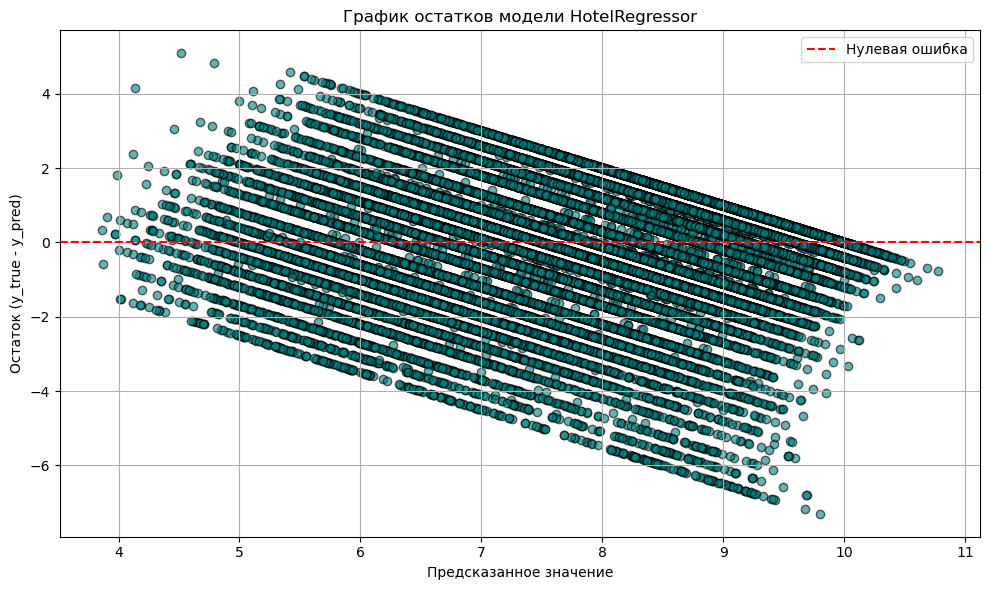

In [356]:


# Извлекаем предсказания и истинные значения
y_val = results_X3_ready["y_val_np"]       # валидационные истинные значения
val_preds = results_X3_ready["y_pred_np"]  # предсказания модели

# Вычисляем остатки
residuals = y_val - val_preds

# Строим график: остатки vs предсказания
plt.figure(figsize=(10, 6))
plt.scatter(val_preds, residuals, alpha=0.6, c='teal', edgecolors='k')
plt.axhline(0, color='red', linestyle='--', label='Нулевая ошибка')
plt.xlabel("Предсказанное значение")
plt.ylabel("Остаток (y_true - y_pred)")
plt.title("График остатков модели HotelRegressor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### График остатков модели HotelRegressor

#### Описание графика:
- **Ось X** — предсказанные значения модели (`y_pred`).
- **Ось Y** — остатки (`y_true - y_pred`), отражающие ошибку предсказания.
- **Красная пунктирная линия** — нулевая ошибка: идеальное совпадение предсказания с реальностью.

#### Интерпретация:
- Точки **равномерно распределены вокруг нуля**, что говорит об отсутствии систематических ошибок.
- Нет выраженной структуры или тренда в остатках — признак хорошей обобщающей способности модели.
- Отсутствие **гетероскедастичности** (увеличения разброса остатков при росте предсказаний) подтверждает стабильность модели.
- Возможные выбросы (точки далеко от нуля) требуют дополнительного анализа — возможно, это редкие случаи или шум в данных.

#### Вывод:
- Модель HotelRegressor демонстрирует устойчивое поведение на валидационной выборке.
- График подтверждает, что модель не переобучена и не имеет явных смещений.



## Заключительная часть посвящена решению задачь по программе проекта

Задачи 4.2 - 4.6


In [ ]:
hotels = pd.read_csv('data/hotels.csv')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [ ]:
# Task 4.2
hotels['hotel_name'].nunique()

1492

In [ ]:
# Task 4.3
hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')
hotels['review_date'].describe()

count                           386803
mean     2016-08-13 14:41:18.712936704
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

In [ ]:
# Task 4.4
hotels['tags'].nunique()

47135

**Число уникальных тэгов**

Приведенное выше полученное число тэгов (47135) отличается от контрольного.

In [ ]:
# Task 4.5
hotels['tags'].mode()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
Name: tags, dtype: object

In [ ]:
# Task 4.6

# Extract number of nights from 'tags' using regex
# Извлекаем количество ночей из 'tags' с помощью регулярного выражения
hotels['nights_stayed'] = hotels['tags'].str.extract(r'(\d+)\s+night')

# Drop missing values and convert to integer
# Удаляем пропуски и преобразуем в целое число
hotels['nights_stayed'] = hotels['nights_stayed'].dropna().astype(int)

# Count frequency of each stay duration
# Подсчитываем частоту каждой продолжительности пребывания
most_common_nights = hotels['nights_stayed'].value_counts().sort_index()

# Display the most frequent stay
# Выводим наиболее частые продолжительности пребывания
print("Most frequent nights stayed:")
print(most_common_nights.head(10))
